# Обработка отзывов о мобильных телефонах

Дано: датасет с русскоязычными отзывами о мобильных телефонах с выставленным рейтингом от 1 до 5.
Задача – обучить любую модель регрессии (или классификации, если решите таким путём пойти) из пакетов scikit, XGBoost, LightGBM, CatBoost.
Необходимая метрика:
1.	Со звёздочкой (дополнительный балл) – MAE <= 0.5
2.	Минимальное допустимое значение – МАЕ <= 1.0


# Предварительная обработка текстов

## Установка библиотек

In [184]:
#!pip install --upgrade pandas
#!pip install nltk
!pip install transformers

     ---------------------------------------- 0.0/43.7 kB ? eta -:--:--
     ----------------- -------------------- 20.5/43.7 kB 320.0 kB/s eta 0:00:01
     -------------------------------------- 43.7/43.7 kB 423.0 kB/s eta 0:00:00
  Using cached tokenizers-0.19.1-cp311-none-win_amd64.whl.metadata (6.9 kB)
   ---------------------------------------- 0.0/9.5 MB ? eta -:--:--
   ---------------------------------------- 0.1/9.5 MB 1.7 MB/s eta 0:00:06
    --------------------------------------- 0.2/9.5 MB 2.0 MB/s eta 0:00:05
   - -------------------------------------- 0.3/9.5 MB 2.5 MB/s eta 0:00:04
   -- ------------------------------------- 0.5/9.5 MB 3.0 MB/s eta 0:00:04
   ---- ----------------------------------- 1.0/9.5 MB 4.6 MB/s eta 0:00:02
   ------ --------------------------------- 1.5/9.5 MB 5.5 MB/s eta 0:00:02
   -------- ------------------------------- 2.0/9.5 MB 6.4 MB/s eta 0:00:02
   ---------- ----------------------------- 2.5/9.5 MB 7.1 MB/s eta 0:00:01
   ------------

In [185]:
import pandas as pd
import numpy as np
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from catboost import CatBoostRegressor, CatBoostClassifier, Pool
from catboost import EFstrType
from sklearn.pipeline import Pipeline
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from math import sqrt
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
import warnings
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from nltk import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import nltk
import pickle
nltk.download('punkt')
from nltk import tokenize
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
from pymystem3 import Mystem
mystem_analyzer = Mystem()
import re
from string import punctuation
from collections import Counter
from tqdm import tqdm
from pymorphy3 import MorphAnalyzer
from transformers import AutoModelForSeq2SeqLM, T5TokenizerFast

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\term\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\term\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Константы

In [3]:
LOCAL_PATH = 'D:/_DS/Edu/NLP_1_flow/Homework_1/'
RANDOM_STATE = RS = 654321
TEST_SIZE = .25
# выделение в тексте
BOLD = "\033[1m"
ITALIC = "\033[3m"
END = "\033[0m"
CR = '\n'

## Вспомогательные функции

In [4]:
# Функция, выводящая основную информацию о датафрейме
def about_df(data, size=5):
    print (BOLD + 'Изучим исходные данные' + END)
    print(data.info())
    print(BOLD + CR + f'Вывод первых {size} строк датафрейма:' + END)
    display(data.head(size))
    print(BOLD + CR + 'Вывод основной информации о датафрейме:' + END)
    print(CR + 'Количество строк: ', data.shape[0])
    print('Количество столбцов: ', data.shape[1])
    categ_col = data.columns[data.dtypes == 'object']
    num_col = data.columns[data.dtypes != 'object']
    print('Количество категориальных признаков: ', len(categ_col))
    print('Количество числовых признаков: ', len(num_col))
    missed_cells = data.isna().sum().sum()/(data.shape[0]*(data.shape[1]-1))
    missed_rows = sum(data.isna().sum(axis = 1)>0)/data.shape[0]
    print (BOLD + CR + 'Проверка пропусков'+ END)
    print ('Количество пропусков: {:.0f}'.format(data.isnull().sum().sum()))
    print ('Доля пропусков: {:.1%}'.format(missed_cells)+ END)
    print ('Доля строк содержащих пропуски: {:.1%}'.format(missed_rows))
    print(BOLD +  CR + 'Описание количественных данных:'+ END)
    display(pd.concat([pd.DataFrame(np.array([data[num_col].isna().sum(), data[num_col].isna().mean()*100]).T,
                                columns=['кол-во пропусков', 'доля пропусков, %'], index=data[num_col].columns), data.describe().T], axis=1))
    print(BOLD + CR + 'Описание категориальных данных:'+ '\033[0m')
    display(pd.concat([pd.DataFrame(np.array([data[categ_col].isna().sum(), data[categ_col].isna().mean()*100]).T,
                                columns=['кол-во пропусков', 'доля пропусков, %'], index=data[categ_col].columns), data.describe(include='object').T], axis=1))
    ## Проверим дубликаты
    print (BOLD +  CR + 'Проверка на дубликаты'+ END)
    print('Количество полных дубликатов: ', data.duplicated().sum())
        

## Чтение данных

Наши данные выгружены в текстовом виде. Посмотрим на них:

In [5]:
with open(LOCAL_PATH + 'data.csv', 'r', encoding='utf-8')as f:
    comments_text = f.read()

In [6]:
comments_text[:1500]

'Review,Rating\n3D Touch просто восхитительная вещь! Заряд держит целый день. В розовом цвете смотрится очень необычно. Touch ID очень быстрый и удобный. Всем советую этот телефон!,5\n"Отключается при температуре близкой к нулю, непонятно ведет себя батарея",4\n"В Apple окончательно решили не заморачиваться, делая незначительные изменения в телефоне, выдают эти изменения за инновации. На этот раз скопировали не только функционал, но и дизайн. Цена и была неадекватно завышена, а после скачка курса так и говорить об этом не приходится. Многие скажут, что и HD разрешения будет достаточно для такой диагонали, может так оно и есть, но аппарат позиционируется, как топовое решение, а в итоге получаем банальную экономию производителя, ведь что произойдёт с временем работы, если увеличить до FHD?! 1 гб оперативки тоже прошлый век! И не надо рассказывать сказки про великолепную оптимизацию iOS, чудес на свете не бывает, этого мало. Те кто скажет, что их не волнуют технические характеристики смар

Так, разделитель - запятая, 2 колонки, отзыв и рейтинг.

In [7]:
data = pd.read_csv(LOCAL_PATH + 'data.csv', sep=',')

In [8]:
data.head()

,Review,Rating
0,3D Touch просто восхитительная вещь! Заряд дер...,5
1,"Отключается при температуре близкой к нулю, не...",4
2,"В Apple окончательно решили не заморачиваться,...",3
3,Постарался наиболее ёмко и коротко описать все...,4
4,Достойный телефон. Пользоваться одно удовольст...,5


In [9]:
data.tail()

,Review,Rating
458428,"удобный, всё работает отлично, звонит, играет,...",5
458429,"прошло больше года, притензий нет, при моей на...",5
458430,мой первый аппарат на андроиде. На данный моме...,5
458431,Разбил iphone и не было желания покупать новый...,5
458432,Очень доволен покупкой и всем советую...,5


In [10]:
about_df(data)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458433 entries, 0 to 458432
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Review  457837 non-null  object
 1   Rating  458433 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 7.0+ MB
None

Вывод первых 5 строк датафрейма:


,Review,Rating
0,3D Touch просто восхитительная вещь! Заряд дер...,5
1,"Отключается при температуре близкой к нулю, не...",4
2,"В Apple окончательно решили не заморачиваться,...",3
3,Постарался наиболее ёмко и коротко описать все...,4
4,Достойный телефон. Пользоваться одно удовольст...,5



Вывод основной информации о датафрейме:

Количество строк:  458433
Количество столбцов:  2
Количество категориальных признаков:  1
Количество числовых признаков:  1

Проверка пропусков
Количество пропусков: 596
Доля пропусков: 0.1%
Доля строк содержащих пропуски: 0.1%

Описание количественных данных:


,кол-во пропусков,"доля пропусков, %",count,mean,std,min,25%,50%,75%,max
Rating,0.0,0.0,458433.0,4.000853,1.266496,0.0,3.0,4.0,5.0,9.0



Описание категориальных данных:


,кол-во пропусков,"доля пропусков, %",count,unique,top,freq
Review,596.0,0.130008,457837,320031,Отличный телефон,114



Проверка на дубликаты
Количество полных дубликатов:  137327


У нас хорошо заполненный датасет с небольшим количчеством пропусков, тем не менее пропуски есть в текстовой части отзыва и такие отзывы нам не годятся для модели. Дропнем

In [11]:
data = data.dropna().reset_index(drop = True)

Проверка на дубликаты показала 137327 полных дубликатов. Нужно посмотреть.

In [12]:
data[data.duplicated()== True]

,Review,Rating
343,"Покупал 6-ку в интернет магазине, перед этими ...",4
354,Довольно долго сопротивлялся смартфонам. Да и ...,5
358,"Всем заядлым ""яблочникам"" хочу сказать,что чув...",4
359,"Отличный, как и все айфоны, но цены очень высока.",5
361,"Очень понравился телефон в использовании, мне ...",5
...,...,...
457746,"Телефон стоит денег, которые я за него заплати...",4
457747,"Телефон стоит денег, которые я за него заплати...",4
457753,"Конечно, это может быть брак конкретно моего т...",4
457766,не советую брать,1


In [13]:
data[data['Review'] == 'не советую брать']

,Review,Rating
9983,не советую брать,1
19665,не советую брать,1
76500,не советую брать,3
79750,не советую брать,1
322346,не советую брать,1
348307,не советую брать,3
370268,не советую брать,3
398386,не советую брать,3
428893,не советую брать,1
436844,не советую брать,2


Вполне возможно,что это блоки из одинаковых ответов разных пользователей. Пока не удаляем.

In [14]:
#data = data.drop_duplicates().reset_index(drop = True)

Что осталось?

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 457837 entries, 0 to 457836
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Review  457837 non-null  object
 1   Rating  457837 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 7.0+ MB


Убрав дубликаты мы бы потеряли треть! Ну ничего, спокойно посмотрим дальше.

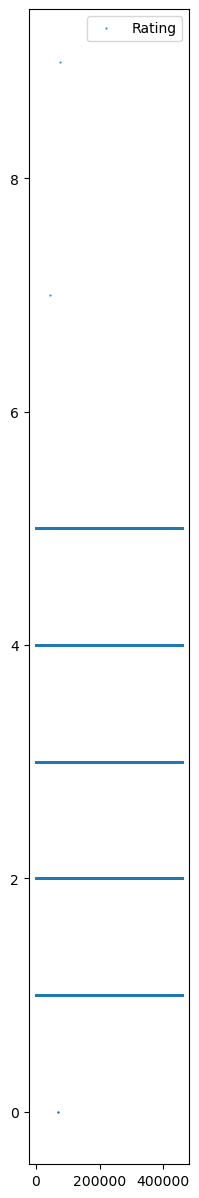

In [16]:
data.plot(
    lw=0, marker=".", subplots=True, layout=(-1, 5), figsize=(12, 15), markersize=1
);

Минуточку, а что это за рейтинг больше 5? Если рейтинг до 9, то у нас тут мешок плохих отзывов, так не бывает. Нет, бывает, но предполагаем. что это не так.

In [17]:
print(data[data['Rating']>5])

                                                  Review  Rating
44271  Очень приятный телефон, постоянно хочется его ...       7
77154  Искал аппарат с большой батареей (много разгов...       9


In [18]:
data['Review'][44271]   

'Очень приятный телефон, постоянно хочется его держать в руках, настолько он приятен. В черном цвете выглядит шикарно.\rSamsung Pay - довольно удобная штука, сразу стала ею пользоваться.\rСканер отпечатков работает довольно точно и очень быстро - стоит только приложить палец к кнопке (нажимать на нее не нужно) - и он уже разблокирован.\rНа удивление, очень яркая вспышка, но это мелочь.\rUSB Type C.. ну, честно говоря, не понимаю, почему всем он так нужен, как по мне - ничего необходимого в нем нет, никогда не было проблем с Micro USB.\rБатарейку держит нормально - день работы с постоянным ВК, чтением, парой фоток и десятиминутной GPS-навигацией за день - легко, но буду смотреть дальше, т.к. пользуюсь им еще не так долго.\r\rВ общем, если вы хотите просто хороший смартфон'

In [19]:
data['Review'][77154]   

'Искал аппарат с большой батареей (много разговариваю, поэтому ёмкость'

Это хороший отзыв и оборванный отзыв, приведем в соответствие

In [20]:
data.loc[data['Rating']==7, 'Rating'] = 5
data = data[data['Rating']<9]

In [21]:
data['Rating'].value_counts()

Rating
5    228087
4    106503
3     53055
2     35705
1     34484
0         2
Name: count, dtype: int64

In [22]:
data[data['Rating']==0]['Review']

69369    Был приверженцем HTC, но что-то тайванские тов...
69398    Был приверженцем HTC, но что-то тайванские тов...
Name: Review, dtype: object

In [23]:
data['Review'][69369]   

'Был приверженцем HTC, но что-то тайванские товарищи уже несколько лет не могут родить нормальный флагман, пришлось смотреть хоть какой-то телефон взамен старому. Изначально планировал просто взять какой-нибудь бюджетный аппарат ('

Ещё один оборванный отзыв с непонятной тональностью, обрезаем.

In [24]:
data = data[data['Rating']>0]

In [25]:
data = data.reset_index(drop = True)

Посмотрим на распределение таргета:

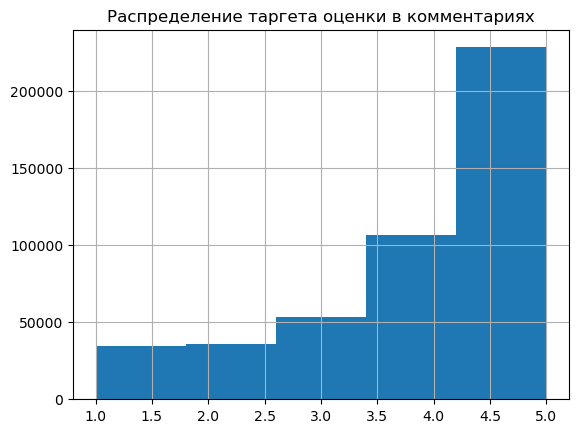

In [26]:
pd.Series(data['Rating']).hist( bins = 5)
plt.title('Распределение таргета оценки в комментариях')
plt.show()

## Бэйзлайн модель

Кэтбуст неплохо переваривает текст, сделаем на его основе базовую модель для последующего сравнения

In [27]:
y =target = data['Rating']

In [28]:
X = data.drop('Rating', axis = 1)


In [29]:
X.head()

,Review
0,3D Touch просто восхитительная вещь! Заряд дер...
1,"Отключается при температуре близкой к нулю, не..."
2,"В Apple окончательно решили не заморачиваться,..."
3,Постарался наиболее ёмко и коротко описать все...
4,Достойный телефон. Пользоваться одно удовольст...


In [30]:
train_x, test_x, train_y, test_y = train_test_split(X, y,
                                                   test_size=TEST_SIZE, random_state=RS,
                                                   )

In [31]:
print(data.shape)
print(test_x.shape)
print(test_x.shape)

(457834, 2)
(114459, 1)
(114459, 1)


In [32]:
text_features = ['Review']

def objective(trial):
    param = {
        "iterations": trial.suggest_int("iterations", 200, 2400),
        "depth": trial.suggest_int("depth", 2, 6),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 5),
        #"colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.08, 0.1),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli"]),# "MVS"])
         "task_type": "GPU" 
    }
    train_pool = Pool(train_x,
                  label=train_y,
                  text_features=text_features
                      )
    test_pool = Pool(test_x,
                  label=test_y,
                  text_features=text_features
                  )
    model_cbc = CatBoostRegressor(**param, 
                                   loss_function = 'RMSE',
                                   eval_metric = 'RMSE',
                                   thread_count=-1, 
                                   random_seed=RANDOM_STATE, 
                                   verbose=0, 
                                   text_features=text_features
                                 )
    predict_cbc = cross_val_predict(model_cbc, train_x, train_y, cv=4)
    score_cbc = mean_absolute_error(train_y, predict_cbc)
    return score_cbc
sampler = optuna.samplers.RandomSampler(seed=RANDOM_STATE)
study_cbc = optuna.create_study(sampler=sampler, direction='minimize')
study_cbc.optimize(objective, n_trials=10)
print('Best hyperparameters Catboost:', study_cbc.best_params)
print('Best MAE Catboost:', study_cbc.best_value)


[I 2024-04-24 16:04:25,471] A new study created in memory with name: no-name-5c4b7593-b45a-46de-9d4c-4655ee6a00b2
[I 2024-04-24 16:05:07,159] Trial 0 finished with value: 0.8658033727743734 and parameters: {'iterations': 710, 'depth': 5, 'l2_leaf_reg': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 0.8658033727743734.
[I 2024-04-24 16:05:52,347] Trial 1 finished with value: 0.9317033865493553 and parameters: {'iterations': 357, 'depth': 2, 'l2_leaf_reg': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 0 with value: 0.8658033727743734.
[I 2024-04-24 16:07:19,876] Trial 2 finished with value: 0.8670913892254375 and parameters: {'iterations': 1196, 'depth': 3, 'l2_leaf_reg': 2, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 0 with value: 0.8658033727743734.
[I 2024-04-24 16:09:38,714] Trial 3 finished with value: 0.8301214122583268 and parameters: {'iterations': 1792, 'depth': 5, 'l2_leaf_reg': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian'}. Best is trial 3 with value: 0.8301214122583268.
[I 2024-04-24 16:10:49,655] Trial 4 finished with value: 0.8667665275069081 and parameters: {'iterations': 691, 'depth': 5, 'l2_leaf_reg': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian'}. Best is trial 3 with value: 0.8301214122583268.
[I 2024-04-24 16:12:56,459] Trial 5 finished with value: 0.8625203214935213 and parameters: {'iterations': 2161, 'depth': 2, 'l2_leaf_reg': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 3 with value: 0.8301214122583268.
[I 2024-04-24 16:13:32,002] Trial 6 finished with value: 0.9186172185520529 and parameters: {'iterations': 516, 'depth': 2, 'l2_leaf_reg': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian'}. Best is trial 3 with value: 0.8301214122583268.
[I 2024-04-24 16:15:58,802] Trial 7 finished with value: 0.8334130127253915 and parameters: {'iterations': 2096, 'depth': 4, 'l2_leaf_reg': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli'}. Best is trial 3 with value: 0.8301214122583268.
[I 2024-04-24 16:16:38,867] Trial 8 finished with value: 0.8789070000677444 and parameters: {'iterations': 518, 'depth': 5, 'l2_leaf_reg': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli'}. Best is trial 3 with value: 0.8301214122583268.
[I 2024-04-24 16:17:15,156] Trial 9 finished with value: 0.8992702483486947 and parameters: {'iterations': 328, 'depth': 5, 'l2_leaf_reg': 4, 'boosting_type': 'Plain', 'boo

Best hyperparameters Catboost: {'iterations': 1792, 'depth': 5, 'l2_leaf_reg': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian'}
Best MAE Catboost: 0.8301214122583268


In [33]:
model_cb = CatBoostRegressor(iterations=1792,
                                depth=5,
                                #learning_rate=0.001,
                                l2_leaf_reg=5,
                                boosting_type='Ordered',
                                loss_function='RMSE',
                                eval_metric = 'RMSE',
                                thread_count=-1, 
                                random_seed=RANDOM_STATE, 
                                verbose=0, 
                                text_features=text_features,
                                task_type = "GPU" 
)


model_cb.fit(train_x, train_y, text_features=text_features, plot= True)
y_pred = model_cb.predict(test_x)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [34]:
mse = mean_squared_error(test_y, y_pred)

rmse = root_mean_squared_error(test_y, y_pred)
mae = mean_absolute_error(test_y, y_pred)
print("Root Mean Squared Error на тестовой выборке:", rmse)
print("Mean Absolute Error на тестовой выборке:", mae)
r2 = r2_score(test_y, y_pred)
print("R2 на тестовой выборке:", r2)

Root Mean Squared Error на тестовой выборке: 1.0573443187000018
Mean Absolute Error на тестовой выборке: 0.8310417344282175
R2 на тестовой выборке: 0.3026942533407161


In [35]:
y_pred

array([4.19069358, 3.19785718, 4.176447  , ..., 2.717073  , 4.11856958,
       4.17545681])

Хм, так то у нас хорошие целочисленные значения, можно и классификацию замутить

def objective(trial):
    param = {
        "iterations": trial.suggest_int("iterations", 200, 2400),
        "depth": trial.suggest_int("depth", 2, 6),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 5),
        #"colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.08, 0.1),
        #"boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli"]),# "MVS"])
         "task_type": "GPU" 
    }
    train_pool = Pool(train_x,
                  label=train_y,
                  text_features=text_features
                      )
    test_pool = Pool(test_x,
                  label=test_y,
                  text_features=text_features
                  )
    model_cbc = CatBoostClassifier(**param, 
                                   loss_function = 'MultiClass',
                                   thread_count=-1, 
                                   random_seed=RANDOM_STATE, 
                                   verbose=0, 
                                   text_features=text_features
                                 )
    predict_cbc = cross_val_predict(model_cbc, train_x, train_y, cv=4)
    score_cbc = mean_absolute_error(train_y, predict_cbc)
    return score_cbc
sampler = optuna.samplers.RandomSampler(seed=RANDOM_STATE)
study_cbc = optuna.create_study(sampler=sampler, direction='minimize')
study_cbc.optimize(objective, n_trials=10)
print('Best hyperparameters Catboost:', study_cbc.best_params)
print('Best MAE Catboost:', study_cbc.best_value)



[I 2024-04-24 16:25:19,613] A new study created in memory with name: no-name-402793fc-ff45-429b-b9dd-0039ec644fdd
[I 2024-04-24 16:26:28,394] Trial 0 finished with value: 0.6077301265654586 and parameters: {'iterations': 710, 'depth': 5, 'l2_leaf_reg': 5, 'bootstrap_type': 'Bernoulli'}. Best is trial 0 with value: 0.6077301265654586.
[I 2024-04-24 16:28:02,041] Trial 1 finished with value: 0.6128417433478391 and parameters: {'iterations': 2045, 'depth': 2, 'l2_leaf_reg': 1, 'bootstrap_type': 'Bernoulli'}. Best is trial 0 with value: 0.6077301265654586.
[I 2024-04-24 16:29:27,683] Trial 2 finished with value: 0.615333189383118 and parameters: {'iterations': 1709, 'depth': 2, 'l2_leaf_reg': 1, 'bootstrap_type': 'Bernoulli'}. Best is trial 0 with value: 0.6077301265654586.
[I 2024-04-24 16:30:36,369] Trial 3 finished with value: 0.6139006079128326 and parameters: {'iterations': 993, 'depth': 3, 'l2_leaf_reg': 3, 'bootstrap_type': 'Bernoulli'}. Best is trial 0 with value: 0.6077301265654586.
[I 2024-04-24 16:32:31,767] Trial 4 finished with value: 0.5927980599940206 and parameters: {'iterations': 1914, 'depth': 5, 'l2_leaf_reg': 4, 'bootstrap_type': 'Bayesian'}. Best is trial 4 with value: 0.5927980599940206.
[I 2024-04-24 16:33:46,187] Trial 5 finished with value: 0.6042296448858918 and parameters: {'iterations': 865, 'depth': 5, 'l2_leaf_reg': 1, 'bootstrap_type': 'Bernoulli'}. Best is trial 4 with value: 0.5927980599940206.
[I 2024-04-24 16:35:47,568] Trial 6 finished with value: 0.5869556190412916 and parameters: {'iterations': 1689, 'depth': 6, 'l2_leaf_reg': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 6 with value: 0.5869556190412916.
[I 2024-04-24 16:37:23,516] Trial 7 finished with value: 0.6131780885626017 and parameters: {'iterations': 2161, 'depth': 2, 'l2_leaf_reg': 4, 'bootstrap_type': 'Bayesian'}. Best is trial 6 with value: 0.5869556190412916.
[I 2024-04-24 16:38:18,576] Trial 8 finished with value: 0.6206856459489087 and parameters: {'iterations': 520, 'depth': 3, 'l2_leaf_reg': 1, 'bootstrap_type': 'Bayesian'}. Best is trial 6 with value: 0.5869556190412916.
[I 2024-04-24 16:39:40,726] Trial 9 finished with value: 0.6059985715709397 and parameters: {'iterations': 1218, 'depth': 4, 'l2_leaf_reg': 3, 'bootstrap_type': 'Bernoulli'}. Best is trial 6 with value: 0.5869556190412916.

Best hyperparameters Catboost: {'iterations': 1689, 'depth': 6, 'l2_leaf_reg': 1, 'bootstrap_type': 'Bayesian'}
Best MAE Catboost: 0.5869556190412916


In [36]:
model_cb = CatBoostClassifier(iterations=1689,
                                depth = 6,
                                loss_function='MultiClass',
                                thread_count=-1, 
                                random_seed=RANDOM_STATE, 
                                verbose=0, 
                                text_features=text_features,
                                task_type = "GPU" 
                                
)


model_cb.fit(train_x, train_y, text_features=text_features, plot= True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [37]:
test_pred = model_cb.predict(test_x)
proba_test = model_cb.predict_proba(test_x)

train_pred = model_cb.predict(train_x)
proba_train = model_cb.predict_proba(train_x)
 
test_pred = model_cb.predict(test_x)
confusion = confusion_matrix(test_y, test_pred)
print(CR + classification_report(test_y,test_pred)) 

print(CR + 'Confusion Matrix\n')
print(confusion)
auc_tr = roc_auc_score(train_y, proba_train, multi_class='ovr')
auc_test = roc_auc_score(test_y, proba_test, multi_class='ovr')
print('AUC ROC train: ',auc_tr)
print('AUC ROC test: ',auc_test)
mse = mean_squared_error(test_y, test_pred)
rmse = root_mean_squared_error(test_y, test_pred)
mae = mean_absolute_error(test_y, test_pred)
print("Root Mean Squared Error на тестовой выборке:", rmse)
print("Mean Absolute Error на тестовой выборке:", mae)
r2 = r2_score(test_y, test_pred)
print("R2 на тестовой выборке:", r2)


              precision    recall  f1-score   support

           1       0.55      0.60      0.57      8652
           2       0.55      0.35      0.43      8867
           3       0.51      0.39      0.45     13286
           4       0.57      0.41      0.48     26766
           5       0.72      0.89      0.80     56888

    accuracy                           0.66    114459
   macro avg       0.58      0.53      0.54    114459
weighted avg       0.64      0.66      0.64    114459


Confusion Matrix

[[ 5160   814   863   367  1448]
 [ 1842  3120  1406   875  1624]
 [ 1213   934  5236  2696  3207]
 [  530   445  1811 10934 13046]
 [  589   338   926  4323 50712]]
AUC ROC train:  0.9132641915497771
AUC ROC test:  0.8739398718230651
Root Mean Squared Error на тестовой выборке: 1.0037149562846277
Mean Absolute Error на тестовой выборке: 0.5124542412566946
R2 на тестовой выборке: 0.37163619141479687


Итак, наша базовая модель показала неплохой результат, по заданию минимальное допустимое значение – МАЕ <= 1.0. У нас уже 0.51. Теперь нужно проверить, что удастся сделать самостоятельно. Поехали

In [38]:
text_feature_indices = model_cb.get_feature_importance(Pool(data, label=y, text_features=text_features), 
                                     type=EFstrType.FeatureImportance, prettified=True)

In [39]:
text_feature_indices

,Feature Id,Importances
0,Review,100.0


In [40]:
cat_imp = pd.Series(model_cb.feature_importances_, X.columns)

Text(0.5, 1.0, 'Важность признаков Catboost ')

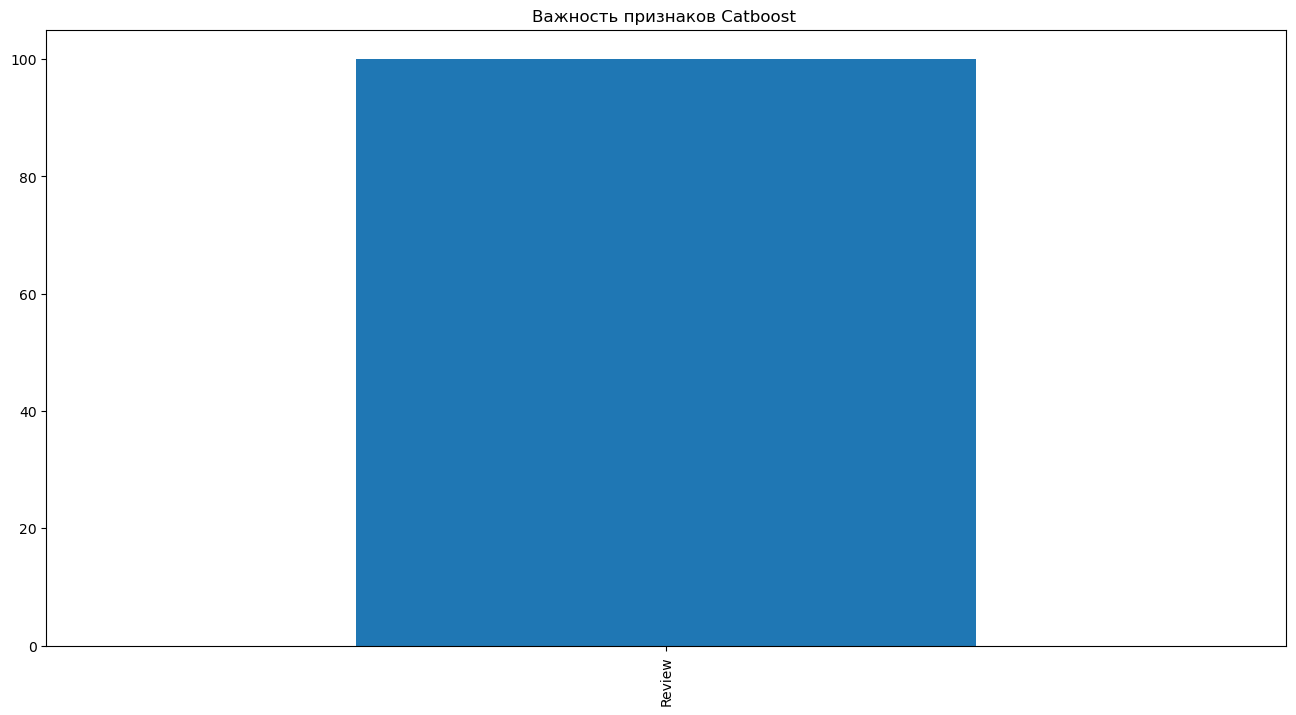

In [41]:
cat_imp.plot.bar(figsize=(16,8)).set_title("Важность признаков Catboost ")

Да, стоит ли удивляться, у нас один, но очень важный признак)))))))))))))

А если немного подработать веса? Предположим, нам важнее отрицательные отзывы

In [42]:
model_cb = CatBoostClassifier(iterations=1689,
                                depth = 6,
                                loss_function='MultiClass',
                                thread_count=-1, 
                                random_seed=RANDOM_STATE, 
                                verbose=0, 
                                text_features=text_features,
                                task_type = "GPU", 
                                class_weights= {1: 2, 2: 2, 3:1, 4:1, 5:1}
)


model_cb.fit(train_x, train_y, text_features=text_features, plot= True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [43]:
test_pred = model_cb.predict(test_x)
proba_test = model_cb.predict_proba(test_x)

train_pred = model_cb.predict(train_x)
proba_train = model_cb.predict_proba(train_x)
 
test_pred = model_cb.predict(test_x)
confusion = confusion_matrix(test_y, test_pred)
print(CR + classification_report(test_y,test_pred)) 

print(CR + 'Confusion Matrix\n')
print(confusion)
auc_tr = roc_auc_score(train_y, proba_train, multi_class='ovr')
auc_test = roc_auc_score(test_y, proba_test, multi_class='ovr')
print('AUC ROC train: ',auc_tr)
print('AUC ROC test: ',auc_test)
mse = mean_squared_error(test_y, test_pred)

rmse = root_mean_squared_error(test_y, test_pred)
mae = mean_absolute_error(test_y, test_pred)
print("Root Mean Squared Error на тестовой выборке:", rmse)
print("Mean Absolute Error на тестовой выборке:", mae)
r2 = r2_score(test_y, test_pred)
print("R2 на тестовой выборке:", r2)


              precision    recall  f1-score   support

           1       0.51      0.67      0.58      8652
           2       0.42      0.50      0.46      8867
           3       0.60      0.28      0.38     13286
           4       0.57      0.39      0.46     26766
           5       0.73      0.88      0.80     56888

    accuracy                           0.65    114459
   macro avg       0.57      0.54      0.54    114459
weighted avg       0.64      0.65      0.63    114459


Confusion Matrix

[[ 5838  1285   230   274  1025]
 [ 2000  4409   532   647  1279]
 [ 1693  2312  3709  2639  2933]
 [  894  1419  1173 10363 12917]
 [ 1039  1006   587  4264 49992]]
AUC ROC train:  0.9123216165355782
AUC ROC test:  0.8726544141589742
Root Mean Squared Error на тестовой выборке: 1.0292764058838815
Mean Absolute Error на тестовой выборке: 0.5308014223433719
R2 на тестовой выборке: 0.3392237768709564


Нет, проверила с разными развесовками, всё плохо, лучшей моделью остаётся кэтбуст с ровными весами.


## Векторизатор

In [44]:
data['Review'].head().tolist()

['3D Touch просто восхитительная вещь! Заряд держит целый день. В розовом цвете смотрится очень необычно. Touch ID очень быстрый и удобный. Всем советую этот телефон!',
 'Отключается при температуре близкой к нулю, непонятно ведет себя батарея',
 'В Apple окончательно решили не заморачиваться, делая незначительные изменения в телефоне, выдают эти изменения за инновации. На этот раз скопировали не только функционал, но и дизайн. Цена и была неадекватно завышена, а после скачка курса так и говорить об этом не приходится. Многие скажут, что и HD разрешения будет достаточно для такой диагонали, может так оно и есть, но аппарат позиционируется, как топовое решение, а в итоге получаем банальную экономию производителя, ведь что произойдёт с временем работы, если увеличить до FHD?! 1 гб оперативки тоже прошлый век! И не надо рассказывать сказки про великолепную оптимизацию iOS, чудес на свете не бывает, этого мало. Те кто скажет, что их не волнуют технические характеристики смартфона, главное 

Извлечём фичи из текстовых данных векторизатором `TfidfVectorizer`


In [45]:
text_features = []
model_cb = CatBoostClassifier(iterations=1689,
                                depth = 6,
                                loss_function='MultiClass',
                                thread_count=-1, 
                                random_seed=RANDOM_STATE, 
                                verbose=0, 
                                task_type = "GPU" 
)


In [46]:
train_x

,Review
286602,"""Отличный аппарат"". Ни кому не советую. Так хо..."
315859,"Хороший телефон, очень нравится. И может кто-н..."
145621,Очень хороший телефон за эти деньги
101118,"Надоело смотреть комменты про то, как у многих..."
373770,"Внешний вид,экран,удобство."
...,...
318635,рекомендую. за свои деньги супер.особенно крас...
332415,"Купили недавно, сначало всё было отлично, пото..."
185599,"Девайс отличный, хотя по моему мнению мог стои..."
237056,сегодня я купил сей девай и очень рад этому в ...


In [47]:
vec_t = TfidfVectorizer(ngram_range=(2, 3), max_df=0.1)
bow_t = vec_t.fit_transform(train_x['Review'])

vec_tr_2_3 = pd.DataFrame.sparse.from_spmatrix(bow_t, columns=vec_t.get_feature_names_out()
                                             )

Уплотнить не удалось, сожмём размерность

In [48]:
pca = PCA(n_components=100)  # Или любое количество компонентов, которое вам нужно


Применяем PCA к данным

In [49]:


pca_result = pca.fit_transform(vec_tr_2_3)


In [50]:
list(vec_t.vocabulary_.items())[:20]


[('отличный аппарат', 6615402),
 ('аппарат ни', 778103),
 ('ни кому', 5833735),
 ('кому не', 4033654),
 ('не советую', 5544021),
 ('советую так', 9302586),
 ('так хотел', 9708077),
 ('хотел его', 10766694),
 ('его купить', 2718327),
 ('купить как', 4268876),
 ('как только', 3732625),
 ('только он', 10132934),
 ('он вышел', 6320592),
 ('вышел теперь', 1940378),
 ('теперь никогда', 9977745),
 ('никогда жизни', 5865138),
 ('жизни не', 2955241),
 ('не возьму', 5385942),
 ('возьму больше', 1542466),
 ('больше htc', 993585)]

самое первое слово - меня. Что же, отзывы наши, конечно всё меряем от себя

In [51]:
vec_tr_2_3


,00 00,00 00 00,00 00 40,00 00 активнейшего,00 00 бывало,00 00 включение,00 00 воскресенья,00 00 даже,00 00 до,00 00 если,...,ґаджет для,ґаджет для людей,ґлобалки когда,ґлобалки когда она,ಠ益ಠლ заменили,ಠ益ಠლ заменили кнопки,为您找到相关结 этот,为您找到相关结 этот момент,魅族 через,魅族 через пару
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343370,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
343371,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
343372,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
343373,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Ого-го, японские иероглифы???! Ну ладно.

In [52]:
vec = TfidfVectorizer(ngram_range=(2, 3), max_df=0.1)
bow_test = vec.fit_transform(test_x['Review'])

vec_test = pd.DataFrame.sparse.from_spmatrix(bow_test, columns=vec.get_feature_names_out())

In [53]:
list(vec.vocabulary_.items())[:20]

[('смартфон целом', 4703715),
 ('целом хороший', 5569313),
 ('хороший экран', 5510760),
 ('экран 08', 5756764),
 ('08 дюйма', 3473),
 ('дюйма хотел', 1373212),
 ('хотел взять', 5519994),
 ('взять не', 692742),
 ('не более', 2750981),
 ('более дюймов', 486890),
 ('дюймов но', 1373678),
 ('но общем', 3046980),
 ('общем удобно', 3186100),
 ('удобно лежит', 5307359),
 ('лежит руке', 2208016),
 ('руке комплекте', 4432254),
 ('комплекте шла', 2057004),
 ('шла пленка', 5738328),
 ('пленка темно', 3587213),
 ('темно серый', 5112202)]

In [54]:
len(vec_tr_2_3), len(vec_test), 

(343375, 114459)

На глубине 6 без РСА  умирало ядро. Уменьшаем глубину до 3, количество итераций. Тот же эффект. Наверное, нужно плотный датасет сделать, сейчас. Нет, плотный датасет не помог, оставим последнюю надежду, РСА.

In [55]:
pca_test = pca.fit_transform(vec_test)

In [56]:
pd.DataFrame(pca_test).head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.004143,-0.002704,-0.000111,0.001850,-0.002944,-0.001413,-0.003117,-0.000655,-0.002177,-0.001900,...,-0.001009,-0.000900,-0.007237,-0.002225,0.000699,0.001558,-0.001281,-0.000713,-0.001335,-0.000445
1,-0.004503,-0.003644,-0.003227,0.000280,-0.002694,-0.001841,-0.003019,-0.000489,-0.001937,-0.002145,...,0.000031,0.001647,0.001179,-0.002398,-0.002278,0.002260,-0.000210,-0.001403,0.001030,-0.001417
2,-0.004350,-0.004138,-0.003746,-0.000639,-0.004580,-0.002280,-0.004618,-0.002446,-0.002582,-0.001932,...,0.007906,-0.014207,0.006667,-0.007824,-0.012921,-0.023103,-0.050701,0.014829,0.015782,0.004875
3,0.013990,0.003255,0.040390,-0.061492,0.004142,0.000916,-0.012187,0.000401,-0.000835,-0.002480,...,0.001199,-0.005552,0.000297,0.002150,-0.000272,-0.008326,0.001933,-0.005807,-0.025237,-0.000646
4,0.000842,0.037376,0.111126,0.109664,-0.007243,-0.006371,-0.012272,-0.007214,0.019895,-0.004357,...,0.007736,0.002830,0.030095,0.022578,-0.009009,0.000081,0.001153,0.003871,0.000371,0.007131


Ну вот получилось что-то. Никаких иероглифов и цифр. Но хватит ли этого для хороших метрик?

In [57]:
model_cb.fit(pca_result, train_y, plot= True)
pred = model_cb.predict(pca_test)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [58]:
test_cat = model_cb.predict(pca_test)
proba_cat = model_cb.predict_proba(pca_test)

train_pred = model_cb.predict(pca_result)
proba_train = model_cb.predict_proba(pca_result)
 
test_pred = model_cb.predict(pca_test)
y_pred=test_pred
confusion = confusion_matrix(test_y, test_pred)

print(CR + classification_report(test_y,test_pred)) 

print(CR + 'Confusion Matrix\n')
print(confusion)
auc_tr = roc_auc_score(train_y, proba_train, multi_class='ovr')
auc_test = roc_auc_score(test_y, proba_test, multi_class='ovr')
print('AUC ROC train: ',auc_tr)
print('AUC ROC test: ',auc_test)


              precision    recall  f1-score   support

           1       0.11      0.03      0.04      8652
           2       0.11      0.04      0.06      8867
           3       0.12      0.04      0.07     13286
           4       0.22      0.14      0.17     26766
           5       0.50      0.77      0.60     56888

    accuracy                           0.42    114459
   macro avg       0.21      0.20      0.19    114459
weighted avg       0.33      0.42      0.35    114459


Confusion Matrix

[[  229   335   473  1317  6298]
 [  193   328   475  1311  6560]
 [  157   337   592  1773 10427]
 [  279   485  1050  3656 21296]
 [ 1173  1369  2339  8241 43766]]
AUC ROC train:  0.8902764401835082
AUC ROC test:  0.8726544141589742


In [59]:
mse = mean_squared_error(test_y, y_pred)

rmse = root_mean_squared_error(test_y, y_pred)
mae = mean_absolute_error(test_y, y_pred)
print("Root Mean Squared Error на тестовой выборке:", rmse)
print("Mean Absolute Error на тестовой выборке:", mae)
r2 = r2_score(test_y, y_pred)
print("R2 на тестовой выборке:", r2)

Root Mean Squared Error на тестовой выборке: 1.6182268720701252
Mean Absolute Error на тестовой выборке: 1.0706279104308092
R2 на тестовой выборке: -0.6333121383340214


Да, дела (((( Очень плохо получилось. И не разобрать, что тут результат TF-IDF, а что - РСА. А без РСА не считалось.

## Токенизация

Токенизируем наш текст.

In [60]:
print(data['Review'].iloc[0].split())

['3D', 'Touch', 'просто', 'восхитительная', 'вещь!', 'Заряд', 'держит', 'целый', 'день.', 'В', 'розовом', 'цвете', 'смотрится', 'очень', 'необычно.', 'Touch', 'ID', 'очень', 'быстрый', 'и', 'удобный.', 'Всем', 'советую', 'этот', 'телефон!']


Так нехорошо, пунктуация остаётся не там

In [61]:
vec.get_feature_names_out()[20:40]

array(['00 13 сентября', '00 14', '00 14 каким', '00 15', '00 15 00',
       '00 16', '00 16 00', '00 17', '00 17 30', '00 20', '00 20 00',
       '00 20 00p', '00 20 подробных', '00 20120125',
       '00 20120125 телефон', '00 24', '00 24 00', '00 29',
       '00 29 вайбер', '00 30'], dtype=object)

Попробуем разбивать текст на слова с использованием регулярных выражений.

In [62]:
import re
regex = re.compile("[А-ЯЁа-яё]+")

def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""


In [63]:
words_only(data['Review'].iloc[0])

'просто восхитительная вещь Заряд держит целый день В розовом цвете смотрится очень необычно очень быстрый и удобный Всем советую этот телефон'

Неплохо, но воспользуемся штатным токенизатором:

In [64]:
word_tokenize(data['Review'].iloc[0])


['3D',
 'Touch',
 'просто',
 'восхитительная',
 'вещь',
 '!',
 'Заряд',
 'держит',
 'целый',
 'день',
 '.',
 'В',
 'розовом',
 'цвете',
 'смотрится',
 'очень',
 'необычно',
 '.',
 'Touch',
 'ID',
 'очень',
 'быстрый',
 'и',
 'удобный',
 '.',
 'Всем',
 'советую',
 'этот',
 'телефон',
 '!']

Идеально, список из всех слов со знаками пунктуации. Обработаем всё:

In [65]:
def get_word_tokens(row):
    try:
        return word_tokenize(row['Review'])
    except:
        return ''
X_tokenized = X.apply(get_word_tokens, axis = 1)

In [66]:
X_tokenized.head()

0    [3D, Touch, просто, восхитительная, вещь, !, З...
1    [Отключается, при, температуре, близкой, к, ну...
2    [В, Apple, окончательно, решили, не, заморачив...
3    [Постарался, наиболее, ёмко, и, коротко, описа...
4    [Достойный, телефон, ., Пользоваться, одно, уд...
dtype: object

## Самые частотные слова отзывов

In [67]:

punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [68]:
corpus = [token for tweet in X.Review for token in word_tokenize(tweet) if token not in punctuation]
print(len(corpus))
corpus[:10]

26631253


['3D',
 'Touch',
 'просто',
 'восхитительная',
 'вещь',
 'Заряд',
 'держит',
 'целый',
 'день',
 'В']

Пунктуация тоже важна, так-то... подумаем, что вернуть, но потом.

In [69]:
freq_dict = Counter(corpus)

freq_dict_sorted= sorted(freq_dict.items(), key=lambda x: -x[1])
freq_dict.most_common(20)

[('и', 809140),
 ('не', 731171),
 ('в', 575878),
 ('на', 468358),
 ('с', 304402),
 ('что', 284317),
 ('телефон', 254452),
 ('но', 220653),
 ('за', 156524),
 ('как', 154638),
 ('очень', 153080),
 ('это', 152684),
 ('для', 148287),
 ('я', 139635),
 ('все', 138509),
 ('по', 136960),
 ('а', 117748),
 ('то', 117078),
 ('у', 115035),
 ('В', 111070)]

Много стоп-слов и я, и "в" и "В" считаются отдельно

Посмотрим на распределение частот слов  по  закону Ципфа. Убедимся, что частотность слов убывает очень быстро.

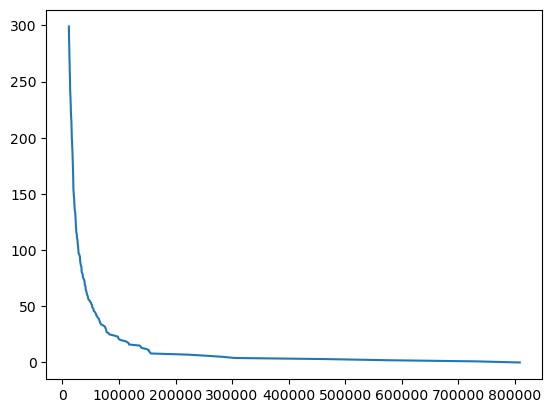

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline

freqs = list(freq_dict.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.show()

Да, убывает стремительно

Ну и на закон Хипса посмотрим по нашему тексту:
С увеличением длины текста (количества токенов), количество слов увеличивается в соответствии с законом,чем больше корпус, тем меньше новых слов добавляется с добавлением новых текстов. В какой-то момент корпус насыщается.



from tqdm import tqdm

cnt = Counter()
n_words = []
n_tokens = []
tokens = []
for index, row in tqdm(data.iterrows(), total = len(data)):
    tokens = word_tokenize(row['Review'])
    cnt.update([token for token in tokens if token not in punctuation])
    n_words.append(len(cnt))
    n_tokens.append(sum(cnt.values()))

fig, ax = plt.subplots()
ax.plot(n_tokens, n_words)
plt.title('закон Хипса '+ CR + ' замедление прироста частот слов'+ CR+'при увеличении числа текстов')
plt.show()

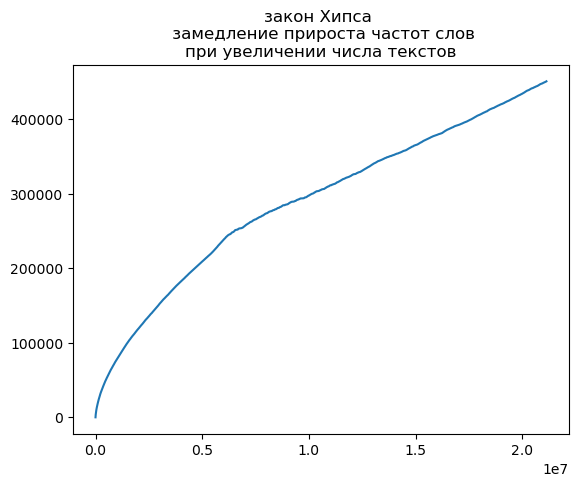

И с помощью этого (очень долгого, надо сказать) кода мы убедились, что закон Хипса на нашем тексте работает, хотя до сильного замедления мы ещё не дошли, нужно больше текстов, но уже замедлились.

## Стоп-слова и пунктуация

Стоп-слова: союзы, связки, местоимения - часто встречаются и не привносят ничего специфического. Этошум и мы их уберём, как и пунктуацию, но с пунктуацией ещё, возможно, поработаем позже.

In [71]:
print(stopwords.words('russian'))

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [72]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [73]:
noise = stopwords.words('russian') + list(punctuation)+ ['``', "''",'--',"//", '/']
len(noise)

188

In [74]:
excl_list = ['хорошо', 'не', 'никогда','ничего', "!", 'нельзя' ]

In [75]:
noise = [x for x in noise if x not in  excl_list]
len(noise)

182

Выберем самые частотные н-граммы. Инициализация CountVectorizer параметрами на 2

In [76]:
vec_cv = CountVectorizer(ngram_range=(2, 3), min_df=0.04, max_df = 0.1, tokenizer=word_tokenize, stop_words=noise)
counts_tr = vec_cv.fit_transform(train_x['Review'])

# Создание DataFrame для удобства работы
df_counts_tr = pd.DataFrame(counts_tr.toarray(), columns=vec_cv.get_feature_names_out())




C:\Users\term\anaconda3\envs\nlpenv\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [77]:
# Подсчёт суммы каждого столбца (биграммы)
df_counts_tr = pd.DataFrame(counts_tr.toarray(), columns=vec_cv.get_feature_names_out())
freq_ngramms = df_counts_tr.sum(axis=0).sort_values(ascending=False)


In [78]:
freq_ngramms[:25]

! !           89214
! ! !         53447
телефон не    14886
dtype: int64

Добавим исключение стоп-слов в векторизатор, аргумент `stop_words`.

In [79]:
vec = CountVectorizer(ngram_range=(2, 3), tokenizer=word_tokenize, stop_words=noise)

In [80]:
vec_tr = TfidfVectorizer(ngram_range=(1, 2), max_df=0.4, tokenizer=word_tokenize, stop_words=noise)
bow_tr = vec_tr.fit_transform(train_x['Review'])

vec_train = pd.DataFrame.sparse.from_spmatrix(bow_tr, columns=vec_tr.get_feature_names_out()
                                             )

C:\Users\term\anaconda3\envs\nlpenv\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [81]:
list_ngramm_imp = vec_train.columns
len(list_ngramm_imp)

4389032

In [82]:
ngramm_imp = vec_train.sum().sort_values(ascending = False)


In [83]:
ngramm_imp.head(20)

!             8488.854352
! !           4440.754048
очень         4261.783304
это           3173.267587
советую       2297.947597
хороший       2260.131937
аппарат       2190.844154
отличный      2187.494951
...           2159.075015
доволен       2107.061294
деньги        2004.827683
просто        1878.714853
целом         1838.061739
модель         1717.48847
года          1650.058915
рекомендую    1614.577132
смартфон      1590.805953
работает       1564.00407
купил         1548.021007
всем          1538.835357
dtype: Sparse[float64, 0]

In [84]:
vec_tr.get_feature_names_out()[:40]


array(['!', '! !', "! 'пентайл", '! ++++++++++++++++++++++++++++++++++',
       '! +-20000', '! +/-', '! +100500', '! +32+38', '! +5', '! +вкл',
       '! +живучесть.сколько', '! +и-', '! +интересно', '! +камера',
       '! +ко', '! +куча', '! +минусы', '! +обнаружили', '! +от',
       '! +потрясающий', '! +прям', '! +умеет', '! +флеха', '! ,тем',
       '! -/-/-/перешёл', '! -10', '! -100/10', '! -38', '! -battery',
       '! -d', '! -wlan', '! -а', '! -автофокуса', '! -аккума',
       '! -аккумулятор', '! -батарея', '! -белая', '! -в', '! -вернулся',
       '! -видеоплеер'], dtype=object)

In [85]:
vec_ts = TfidfVectorizer(ngram_range=(1, 2), max_df=0.4, tokenizer=word_tokenize, stop_words=noise)
bow_ts = vec_ts.fit_transform(test_x['Review'])

vec_test = pd.DataFrame.sparse.from_spmatrix(bow_ts, columns=vec_ts.get_feature_names_out()
                                             )

C:\Users\term\anaconda3\envs\nlpenv\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [86]:
len(vec_train), len(vec_test), 

(343375, 114459)

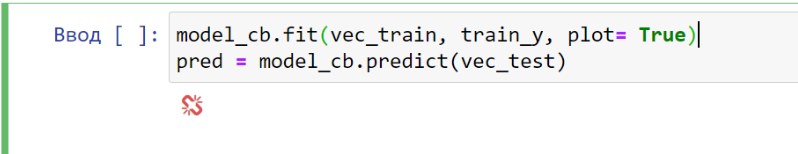

Ядро умирает снова, пойдём через PCA


In [87]:
pca_train = pca.fit_transform(vec_train)

In [88]:
pca_test = pca.fit_transform(vec_test)
pd.DataFrame(pca_test).head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.030902,-0.003461,-0.000297,0.036871,-0.007714,-0.008689,-0.000703,-0.000593,-0.012010,-0.013700,...,-0.030864,-0.042643,-0.059767,-0.041827,0.011724,0.041875,0.004826,0.017294,-0.006215,0.019152
1,-0.029173,-0.017343,-0.008808,-0.008083,-0.003445,-0.013587,0.005615,-0.007455,-0.003878,-0.003755,...,0.019087,0.024147,0.025053,0.016557,0.004819,-0.009156,0.023297,0.006185,0.020433,0.044990
2,0.039636,-0.009470,-0.006676,-0.007110,-0.000210,-0.003244,0.002552,-0.006128,-0.009864,0.004825,...,-0.114074,-0.041260,-0.000941,0.052480,-0.058235,0.011109,-0.017860,-0.004060,0.009527,0.025110
3,-0.028103,0.057876,-0.042493,0.004929,0.010719,-0.028070,0.014853,-0.007752,0.081414,0.001234,...,0.001362,-0.012790,0.009070,-0.008986,-0.005104,-0.005582,-0.003338,0.022097,-0.005499,-0.031724
4,-0.026610,0.118451,0.122995,0.527926,-0.055524,0.056963,-0.113098,0.023286,-0.153560,0.230815,...,-0.033355,0.023281,-0.102434,0.077453,0.066073,-0.099588,0.167270,-0.083508,0.039237,-0.061914


In [89]:
model_cb.fit(pca_train, train_y, plot= True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [90]:
train_pred = model_cb.predict(pca_result)
proba_train = model_cb.predict_proba(pca_result)
 
test_pred = model_cb.predict(pca_test)
proba_test = model_cb.predict_proba(pca_test)

confusion = confusion_matrix(test_y, test_pred)

print(CR + classification_report(test_y,test_pred)) 

print(CR + 'Confusion Matrix\n')
print(confusion)
auc_tr = roc_auc_score(train_y, proba_train, multi_class='ovr')
auc_test = roc_auc_score(test_y,  proba_test, multi_class='ovr')
print('AUC train: ', auc_tr)
print('AUC test: ', auc_test)


              precision    recall  f1-score   support

           1       0.25      0.07      0.11      8652
           2       0.20      0.05      0.08      8867
           3       0.19      0.10      0.13     13286
           4       0.30      0.21      0.25     26766
           5       0.54      0.80      0.65     56888

    accuracy                           0.47    114459
   macro avg       0.30      0.25      0.24    114459
weighted avg       0.40      0.47      0.41    114459


Confusion Matrix

[[  607   526   921  1269  5329]
 [  482   463   967  1520  5435]
 [  384   390  1369  2621  8522]
 [  350   341  1651  5754 18670]
 [  580   562  2350  8000 45396]]
AUC train:  0.5116856825738753
AUC test:  0.6515550099782226


In [91]:
mse = mean_squared_error(test_y, test_pred)

rmse = root_mean_squared_error(test_y, test_pred)
mae = mean_absolute_error(test_y, test_pred)
print("Root Mean Squared Error на тестовой выборке:", rmse)
print("Mean Absolute Error на тестовой выборке:", mae)
r2 = r2_score(test_y, test_pred)
print("R2 на тестовой выборке:", r2)

Root Mean Squared Error на тестовой выборке: 1.4854092817256506
Mean Absolute Error на тестовой выборке: 0.94240732489363
R2 на тестовой выборке: -0.37620343910613285


Лучше? Ну...незначительно. Продолжим изыскания.

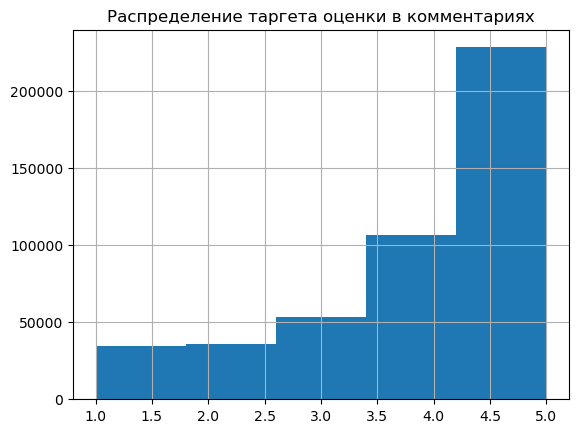

In [92]:
pd.Series(y).hist( bins = 5)
plt.title('Распределение таргета оценки в комментариях')
plt.show()

Так-то распределение в матрице похоже, но мимо - слишком много.

## Лемматизация

Сделаем лемматизацию текстов. Вернем слова к их начальной форме – *лемме*. 


In [93]:
mystem_analyzer.analyze(X['Review'][0])

[{'text': '3D'},
 {'text': ' '},
 {'analysis': [], 'text': 'Touch'},
 {'text': ' '},
 {'analysis': [{'lex': 'просто', 'wt': 0.7704013228, 'gr': 'PART='}],
  'text': 'просто'},
 {'text': ' '},
 {'analysis': [{'lex': 'восхитительный', 'wt': 1, 'gr': 'A=им,ед,полн,жен'}],
  'text': 'восхитительная'},
 {'text': ' '},
 {'analysis': [{'lex': 'вещь', 'wt': 1, 'gr': 'S,жен,неод=(вин,ед|им,ед)'}],
  'text': 'вещь'},
 {'text': '! '},
 {'analysis': [{'lex': 'заряд', 'wt': 1, 'gr': 'S,муж,неод=(вин,ед|им,ед)'}],
  'text': 'Заряд'},
 {'text': ' '},
 {'analysis': [{'lex': 'держать',
    'wt': 1,
    'gr': 'V,несов,пе=непрош,ед,изъяв,3-л'}],
  'text': 'держит'},
 {'text': ' '},
 {'analysis': [{'lex': 'целый',
    'wt': 1,
    'gr': 'A=(вин,ед,полн,муж,неод|им,ед,полн,муж)'}],
  'text': 'целый'},
 {'text': ' '},
 {'analysis': [{'lex': 'день',
    'wt': 0.999920149,
    'gr': 'S,муж,неод=(вин,ед|им,ед)'}],
  'text': 'день'},
 {'text': '. '},
 {'analysis': [{'lex': 'в', 'wt': 0.9999917878, 'gr': 'PR='}]

теперь используем лемматизатор майстема в качестве токенизатора.

In [94]:
def my_preproc(text, stopwords = noise):
    text = re.sub('[{}]'.format(punctuation), '', text)
    text = mystem_analyzer.lemmatize(text)
    return [word for word in text if word not in stopwords]

vec_tr = TfidfVectorizer(ngram_range=(1, 1), max_df=0.4, tokenizer=my_preproc)
bow_tr = vec_tr.fit_transform(train_x['Review'])

vec_train = pd.DataFrame.sparse.from_spmatrix(bow_tr, columns=vec_tr.get_feature_names_out()
                                             )


In [95]:
vec_tr = TfidfVectorizer(ngram_range=(1, 1), max_df=0.4, tokenizer=my_preproc)
bow_ts = vec_ts.fit_transform(test_x['Review'])

vec_test = pd.DataFrame.sparse.from_spmatrix(bow_ts, columns=vec_ts.get_feature_names_out()
                                             )

C:\Users\term\anaconda3\envs\nlpenv\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [96]:
len(vec_train), len(vec_test)

(343375, 114459)

Да, опять слишком большие, РСА:

In [97]:
pca_train = pca.fit_transform(vec_train)
pca_test = pca.fit_transform(vec_test)
pd.DataFrame(pca_test).head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.030902,-0.003461,-0.000297,0.036871,-0.007714,-0.008689,-0.000703,-0.000593,-0.012010,-0.013700,...,-0.030864,-0.042643,-0.059767,-0.041827,0.011724,0.041875,0.004826,0.017294,-0.006215,0.019152
1,-0.029173,-0.017343,-0.008808,-0.008083,-0.003445,-0.013587,0.005615,-0.007455,-0.003878,-0.003755,...,0.019087,0.024147,0.025053,0.016557,0.004819,-0.009156,0.023297,0.006185,0.020433,0.044990
2,0.039636,-0.009470,-0.006676,-0.007110,-0.000210,-0.003244,0.002552,-0.006128,-0.009864,0.004825,...,-0.114074,-0.041260,-0.000941,0.052480,-0.058235,0.011109,-0.017860,-0.004060,0.009527,0.025110
3,-0.028103,0.057876,-0.042493,0.004929,0.010719,-0.028070,0.014853,-0.007752,0.081414,0.001234,...,0.001362,-0.012790,0.009070,-0.008986,-0.005104,-0.005582,-0.003338,0.022097,-0.005499,-0.031724
4,-0.026610,0.118451,0.122995,0.527926,-0.055524,0.056963,-0.113098,0.023286,-0.153560,0.230815,...,-0.033355,0.023281,-0.102434,0.077453,0.066073,-0.099588,0.167270,-0.083508,0.039237,-0.061914


In [98]:
model_cb.fit(pca_train, train_y, plot= True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [99]:
train_pred = model_cb.predict(pca_result)
proba_train = model_cb.predict_proba(pca_result)
 
test_pred = model_cb.predict(pca_test)
proba_test = model_cb.predict_proba(pca_test)

confusion = confusion_matrix(test_y, test_pred)
print(CR + classification_report(test_y,test_pred)) 
print(CR + 'Confusion Matrix\n')
print(confusion)
auc_tr = roc_auc_score(train_y, proba_train, multi_class='ovr')
auc_test = roc_auc_score(test_y,  proba_test, multi_class='ovr')
print('AUC train: ', auc_tr)
print('AUC test: ', auc_test)


              precision    recall  f1-score   support

           1       0.25      0.07      0.11      8652
           2       0.20      0.05      0.08      8867
           3       0.19      0.10      0.13     13286
           4       0.30      0.21      0.25     26766
           5       0.54      0.80      0.65     56888

    accuracy                           0.47    114459
   macro avg       0.30      0.25      0.24    114459
weighted avg       0.40      0.47      0.41    114459


Confusion Matrix

[[  607   526   921  1269  5329]
 [  482   463   967  1520  5435]
 [  384   390  1369  2621  8522]
 [  350   341  1651  5754 18670]
 [  580   562  2350  8000 45396]]
AUC train:  0.5116856825738753
AUC test:  0.6515550099782226


In [100]:
mse = mean_squared_error(test_y, test_pred)
rmse = root_mean_squared_error(test_y, test_pred)
mae = mean_absolute_error(test_y, test_pred)
print("Root Mean Squared Error на тестовой выборке:", rmse)
print("Mean Absolute Error на тестовой выборке:", mae)
r2 = r2_score(test_y, test_pred)
print("R2 на тестовой выборке:", r2)

Root Mean Squared Error на тестовой выборке: 1.4854092817256506
Mean Absolute Error на тестовой выборке: 0.94240732489363
R2 на тестовой выборке: -0.37620343910613285


## Регулярные выражения
Попробуем для нашего не поддающегося пока конкретного случая особый способ токенизации - самостоятельно написать регулярку. Или, 

Создадим отборщики категорий и рег. выражений

In [101]:
vec_tfidf = TfidfVectorizer(ngram_range=(2, 2), max_df=0.4, tokenizer=word_tokenize, stop_words=noise)
bow_5 = vec_tfidf.fit_transform(data[data['Rating']>3]['Review'])


C:\Users\term\anaconda3\envs\nlpenv\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [102]:
vec_df_5 = pd.DataFrame.sparse.from_spmatrix(bow_5, columns=vec_tfidf.get_feature_names_out())

In [103]:
bow_2 = vec_tfidf.fit_transform(data[data['Rating']<=3]['Review'])
vec_df_2 = pd.DataFrame.sparse.from_spmatrix(bow_2, columns=vec_tfidf.get_feature_names_out())

C:\Users\term\anaconda3\envs\nlpenv\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [104]:
# Подсчёт суммы каждого столбца (биграммы)
freq_ngramms_5 = vec_df_5.sum(axis=0).sort_values(ascending=False)
freq_ngramms_2 = vec_df_2.sum(axis=0).sort_values(ascending=False)


In [105]:
freq_ngramms_5[:50]

! !                  5120.475814
отличный телефон     1756.734865
хороший телефон      1499.856758
не пожалеете          1207.34929
свои деньги          1184.751171
очень доволен        1156.871296
очень хороший         924.983363
берите не              899.75485
телефон не            880.940225
всем советую          864.264205
такие деньги          851.562404
телефон очень          829.89759
телефон !             813.860308
своих денег           753.010027
очень довольна        690.465883
не жалею              690.245207
такую цену            690.170089
это не                  652.2861
телефон хороший       650.400511
разу не               650.077977
пока не               608.923866
телефон отличный      598.662518
ничего не             598.154745
отличный аппарат       592.56546
целом телефон         582.049864
очень нравится        568.474537
не очень              564.776884
сих пор               553.189877
советую всем          526.783565
стоит своих           500.305624
советую ! 

In [106]:
freq_ngramms_2[freq_ngramms_2>1]

! !                    2183.491186
не советую             1100.170943
не рекомендую           568.588764
телефон не              548.524396
не стоит                443.257988
                          ...     
связь перезагрузки        1.000029
привыкну фиг               1.00002
4000рублей максимум       1.000013
стоит 4000рублей          1.000013
максимум 500              1.000013
Length: 85184, dtype: Sparse[float64, 0]

In [107]:
freq_ngramms_2 = freq_ngramms_2.reset_index()
freq_ngramms_2

,index,0
0,! !,2183.491186
1,не советую,1100.170943
2,не рекомендую,568.588764
3,телефон не,548.524396
4,не стоит,443.257988
...,...,...
1450099,сим мин,0.024786
1450100,радиостанций новом,0.024786
1450101,нашел шумный,0.024786
1450102,обзора хорошая,0.024786


In [108]:
list_freq_2gramm = set(list(freq_ngramms_2[freq_ngramms_2[0]>1]['index']))
len(list_freq_2gramm)

85184

In [109]:
freq_ngramms_5 = freq_ngramms_5.reset_index()
freq_ngramms_5

,index,0
0,! !,5120.475814
1,отличный телефон,1756.734865
2,хороший телефон,1499.856758
3,не пожалеете,1207.34929
4,свои деньги,1184.751171
...,...,...
3426023,заново запускает,0.019956
3426024,несмотря зарядку,0.019956
3426025,заново грузит,0.019956
3426026,видео дороговато,0.019956


In [110]:
list_freq_ngramm_5 = set(list(freq_ngramms_5[freq_ngramms_5[0]>0]['index']))
len(list_freq_ngramm_5)

3426028

In [111]:

list_only_2_ng = [x for x in list_freq_2gramm if x not in list_freq_ngramm_5]
len(list_only_2_ng)

16619

In [112]:
list_freq_ngramm_5 = set(list(freq_ngramms_5[freq_ngramms_5[0]>1.2]['index']))
len(list_freq_ngramm_5)

180451

In [113]:
list_freq_2gramm = set(list(freq_ngramms_2['index']))
len(list_freq_2gramm)

1450104

In [114]:
list_only_5_ng = [x for x in list_freq_ngramm_5 if x not in list_freq_2gramm]
len(list_only_5_ng)

62326

И мы получили 2 списка н-грамм, характерных каждый для своей категории отзывов, исключив общее. Объединим их:

In [115]:
list_columns_to_check = set(list_only_2_ng+list_only_5_ng)
len(list_columns_to_check)

78945

Теперь снова получаем списки 2-мерных н-грамм трэйна и теста

In [116]:
X= data.drop('Rating',axis = 1)
train_x, test_x, train_y, test_y = train_test_split(X, y,
                                                   test_size=TEST_SIZE, random_state=RS,
                                                   )

In [117]:
vec_tr = TfidfVectorizer(ngram_range=(2, 2), max_df=0.4,  tokenizer=word_tokenize, stop_words=noise)
bow_tr = vec_tr.fit_transform(train_x['Review'])

vec_train = pd.DataFrame.sparse.from_spmatrix(bow_tr, columns=vec_tr.get_feature_names_out()
                                             )


C:\Users\term\anaconda3\envs\nlpenv\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [118]:
vec_ts = TfidfVectorizer(ngram_range=(2, 2), max_df=0.4, tokenizer=word_tokenize, stop_words=noise)
bow_ts = vec_ts.fit_transform(test_x['Review'])

vec_test = pd.DataFrame.sparse.from_spmatrix(bow_ts, columns=vec_ts.get_feature_names_out()
                                             )

C:\Users\term\anaconda3\envs\nlpenv\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Оставляем только те, которые входят в наш дифференциационный лист

In [119]:
list_columns_train_all = set(vec_train.columns)
list_columns_train_left = [x for x in list_columns_to_check if x in list_columns_train_all]

vec_train= vec_train[list_columns_train_left]

In [120]:
list_columns_test_all = set(vec_test.columns)
list_columns_test_left = [x for x in list_columns_train_left if x in list_columns_test_all]


vec_test= vec_test[list_columns_test_left]

In [121]:
list_columns_train_left = set(list_columns_train_left)
list_columns_test_left = set(list_columns_test_left)
list_columns_train_drop = [x for x in list_columns_train_left if x not in list_columns_test_left]
len(list_columns_train_drop)


13860

Наоборот не должно было остаться, но проверим

In [122]:
list_columns_test_drop = [x for x in list_columns_test_left if x not in list_columns_train_left]
len(list_columns_test_drop)

0

In [123]:
vec_train= vec_train.drop(list_columns_train_drop, axis = 1)


In [124]:
vec_train.columns == vec_test.columns 

array([ True,  True,  True, ...,  True,  True,  True])

In [125]:
def check_cat_good(row):
    try:
        for sub_string in strings:
            pattern = re.compile(r'\b{}\b'.format(sub_string+'*'))
            result = pattern.search(row['Review'])
            if result:
                return 1 
    except:
        return 0

strings = [ 'отличный','отличное','отличная','отлично','отличные',
           'доволен','довольна',
           'прекрасный','прекрасно','прекрасные','прекрасное','прекрасная',

           
          ]

X['good_cat'] = X.apply(check_cat_good, axis = 1)
X['good_cat'] = X['good_cat'].fillna(0)
X['good_cat'].value_counts()

good_cat
0.0    354338
1.0    103496
Name: count, dtype: int64

In [126]:
def check_cat_bad(row):
    try:
        for sub_string in strings:
            pattern = re.compile(r'\b{}\b'.format(sub_string+'*'))
            result = pattern.search(row['Review'])
            if result:
                return 1 
    except:
        return 0

strings = [ 'плохо','плох','не совет', 'не рекоменд','не стоит', 'разочарован', 'не берит',
           'отвратительно','отвратительн','сломал', 'обратно в магазин',
           'ужасн', 'пожалел','не покуп', 'перестал работать','ни в коем'
           'жале', 'деньги на ветер'
           
          ]

X['bad_cat'] = X.apply(check_cat_bad, axis = 1)
X['bad_cat'].value_counts()

bad_cat
1.0    30782
Name: count, dtype: int64

In [127]:
X['bad_cat'] = X['bad_cat'].fillna(0)


In [128]:
strings = ['((']# этих нет'(((', ':(((',':(',]

In [129]:
X['bad_smile_cat'] = X.apply(check_cat_bad, axis = 1)
X['bad_smile_cat'].value_counts()

bad_smile_cat
0    457834
Name: count, dtype: int64

In [130]:
strings = [ ')))'] #И этих нет -'🤣', '❤️','😍','😊'] # этих нет ':)))', ':)', ')))']

In [131]:
X['good_smile_cat'] = X.apply(check_cat_good, axis = 1)
X['good_smile_cat'].value_counts()

good_smile_cat
0    457834
Name: count, dtype: int64

Смайлов не нашли. А жаль, могло бы помочь. Но это были очень серьёзные пользователи

In [132]:
pd.crosstab(X['bad_cat'], y).style.background_gradient(cmap='summer_r')

Rating,1,2,3,4,5
bad_cat,,,,,
0.000000,30355,31152,47743,100249,217553
1.000000,4129,4553,5312,6254,10534


Однозначно тут мы не слишком много поймали. Но тем не менее, в 1-2 соотношение 20/3 (около 6), а в 5 152/8(около 19), что говорит о том, что зерно здесь есть.
Кто все эти люди, которые пишут о плохом, но ставят оценку 5??? Хотя плохой может быть и в составе "неплохой". То есть я, конечно, беру от начала слова. Но не все идеально грамотны, кто-то скажет не плохой, с пробелом.

In [133]:
pd.crosstab(X['good_cat'], y).style.background_gradient(cmap='summer_r')

Rating,1,2,3,4,5
good_cat,,,,,
0.000000,32748,33035,47780,81522,159253
1.000000,1736,2670,5275,24981,68834


И наоборот, эта категория показывает соотношение 40/3 в 1-2, и 1/2 в 5. Конечно, хорошо бы ещё поработать, но у меня кончились идеи.

In [134]:
X = X.drop(['good_smile_cat','bad_smile_cat'], axis = 1)

In [135]:
train_x, test_x, train_y, test_y = train_test_split(X, y,
                                                   test_size=TEST_SIZE, random_state=RS,
                                                   )

In [136]:
model_cb = CatBoostClassifier(iterations=1689,
                                depth = 6,
                                loss_function='MultiClass',
                                thread_count=-1, 
                                random_seed=RANDOM_STATE, 
                                verbose=0, 
                                text_features=['Review'],
                                task_type = "GPU" 
                                
)


model_cb.fit(train_x, train_y, text_features=['Review'], plot= True)



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [137]:
test_pred = model_cb.predict(test_x)
proba_test = model_cb.predict_proba(test_x)

train_pred = model_cb.predict(train_x)
proba_train = model_cb.predict_proba(train_x)
 
test_pred = model_cb.predict(test_x)
confusion = confusion_matrix(test_y, test_pred)
print(CR + classification_report(test_y,test_pred)) 

print(CR + 'Confusion Matrix\n')
print(confusion)
auc_tr = roc_auc_score(train_y, proba_train, multi_class='ovr')
auc_test = roc_auc_score(test_y, proba_test, multi_class='ovr')
print('AUC ROC train: ',auc_tr)
print('AUC ROC test: ',auc_test)


              precision    recall  f1-score   support

           1       0.56      0.60      0.58      8652
           2       0.55      0.35      0.43      8867
           3       0.51      0.40      0.45     13286
           4       0.57      0.41      0.48     26766
           5       0.72      0.89      0.80     56888

    accuracy                           0.66    114459
   macro avg       0.58      0.53      0.55    114459
weighted avg       0.64      0.66      0.64    114459


Confusion Matrix

[[ 5177   847   820   383  1425]
 [ 1851  3117  1406   858  1635]
 [ 1201   929  5284  2702  3170]
 [  519   459  1821 10954 13013]
 [  566   329   960  4362 50671]]
AUC ROC train:  0.9136585502688526
AUC ROC test:  0.8746069116782159


In [138]:
mse = mean_squared_error(test_y, test_pred)

rmse = root_mean_squared_error(test_y, test_pred)
mae = mean_absolute_error(test_y, test_pred)
print("Root Mean Squared Error на тестовой выборке:", rmse)
print("Mean Absolute Error на тестовой выборке:", mae)
r2 = r2_score(test_y, test_pred)
print("R2 на тестовой выборке:", r2)

Root Mean Squared Error на тестовой выборке: 0.9999737893978069
Mean Absolute Error на тестовой выборке: 0.5104797351016521
R2 на тестовой выборке: 0.37631168766204226


А было в бэйзлайне:
```
Root Mean Squared Error на тестовой выборке: 1.042193025946871
Mean Absolute Error на тестовой выборке: 0.5508564310183743
R2 на тестовой выборке: 0.31602184690234403
```
И вот у нас побит бэйзлайновый кэтбуст!

Но почему не идеально получилось? отвечу:  получилось потому, что даже по кросстабу хорошей и плохой категории видно - слова встречаются и там и там. А это значит, что нам нужно растащить наши слова на полюса оценок, создав признаки, принадлежащие только своей подгруппе. С одной стороны, это приведёт к переобучению конкретно на этом массиве, потому что язык сложнее, чем биграммы. А с другой стороны - надо попробовать.

# Итоговая модель

In [139]:
model_cb = CatBoostClassifier(iterations=600,
                                depth = 3,
                                loss_function='MultiClass',
                                thread_count=-1, 
                                random_seed=RANDOM_STATE, 
                                verbose=0, 
                                colsample_bylevel = .3
                                #text_features=['Review'],
                                #task_type = "GPU" 
                                
)


model_cb.fit(vec_train, train_y, #text_features=['Review'], 
             plot= True)



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [140]:
test_pred = model_cb.predict(vec_test)
proba_test = model_cb.predict_proba(vec_test)

train_pred = model_cb.predict(vec_train)
proba_train = model_cb.predict_proba(vec_train)
 


In [141]:
confusion = confusion_matrix(test_y, test_pred)
print(CR + classification_report(test_y,test_pred)) 

print(CR + 'Confusion Matrix\n')
print(confusion)
auc_tr = roc_auc_score(train_y, proba_train, multi_class='ovr')
auc_test = roc_auc_score(test_y, proba_test, multi_class='ovr')
print('AUC ROC train: ',auc_tr)
print('AUC ROC test: ',auc_test)


              precision    recall  f1-score   support

           1       0.79      0.02      0.03      8652
           2       0.92      0.00      0.01      8867
           3       0.98      0.00      0.01     13286
           4       0.97      0.01      0.01     26766
           5       0.50      1.00      0.67     56888

    accuracy                           0.50    114459
   macro avg       0.83      0.21      0.14    114459
weighted avg       0.72      0.50      0.34    114459


Confusion Matrix

[[  139     1     0     0  8512]
 [   29    24     1     0  8813]
 [    7     1    46     0 13232]
 [    0     0     0   144 26622]
 [    0     0     0     5 56883]]
AUC ROC train:  0.5451287563881462
AUC ROC test:  0.5372674403591315


In [142]:
vec_train.head()

,телефона твердую,удобно располагается,никапли не,быстр очень,сказать gps,большего глупо,прошивке нареканий,обновить возможности,гладкой задней,купить нужен,...,камера подпортила,люди никого,везучий либо,кажется супер,разу батарея,opera icq,внимание конкурентов,купила осталась,слушать ещё,связи работают
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [143]:
mse = mean_squared_error(test_y, test_pred)

rmse = root_mean_squared_error(test_y, test_pred)
mae = mean_absolute_error(test_y, test_pred)
print("Root Mean Squared Error на тестовой выборке:", rmse)
print("Mean Absolute Error на тестовой выборке:", mae)
r2 = r2_score(test_y, test_pred)
print("R2 на тестовой выборке:", r2)

Root Mean Squared Error на тестовой выборке: 1.6057476334694214
Mean Absolute Error на тестовой выборке: 0.9927048113298211
R2 на тестовой выборке: -0.6082181287552746


И мы видим, что наш метод действительно растащил к полюсам оценки, правда, на южный полюс положительных оценок забрал куда больше. Но впрервые в этом сезоне модель преодолела отметку 1 по MSE:
Root Mean Squared Error на тестовой выборке: 1.6029325352461365
Mean Absolute Error на тестовой выборке: 0.9936343818125195
R2 на тестовой выборке: -0.617992085301591
Не думаю, что это очень честная оценка, учитывая дисбаланс классов. Да, и получается, что я выкинула биграммы троечников. Пересчитаем ещё раз, на этот раз с тройками:

In [144]:
vec_tfidf = TfidfVectorizer(ngram_range=(1, 2), max_df=0.4, tokenizer=word_tokenize, stop_words=noise)
bow_5 = vec_tfidf.fit_transform(data[data['Rating']>3]['Review'])


C:\Users\term\anaconda3\envs\nlpenv\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [145]:
vec_df_5 = pd.DataFrame.sparse.from_spmatrix(bow_5, columns=vec_tfidf.get_feature_names_out())

In [146]:
bow_2 = vec_tfidf.fit_transform(data[data['Rating']<=3]['Review'])
vec_df_2 = pd.DataFrame.sparse.from_spmatrix(bow_2, columns=vec_tfidf.get_feature_names_out())

C:\Users\term\anaconda3\envs\nlpenv\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [147]:
bow_3 = vec_tfidf.fit_transform(data[data['Rating']==3]['Review'])
vec_df_3 = pd.DataFrame.sparse.from_spmatrix(bow_3, columns=vec_tfidf.get_feature_names_out())

C:\Users\term\anaconda3\envs\nlpenv\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [148]:
# Подсчёт суммы каждого столбца (биграммы)
freq_ngramms_5 = vec_df_5.sum(axis=0).sort_values(ascending=False)
freq_ngramms_3 = vec_df_3.sum(axis=0).sort_values(ascending=False)
freq_ngramms_2 = vec_df_2.sum(axis=0).sort_values(ascending=False)


In [149]:
freq_ngramms_5[:50]

!                    8479.51802
очень                4539.71393
! !                 4263.714313
это                 3076.552287
отличный            2670.258768
хороший             2609.287677
доволен             2492.933622
аппарат             2330.656651
советую             2175.514331
деньги              2043.363818
целом               2028.467875
просто              1859.630641
...                 1855.434195
всем                1821.493182
смартфон             1727.71704
рекомендую          1707.144609
работает             1676.34307
пользуюсь           1669.041708
модель              1644.386176
года                 1636.04618
камера              1519.589716
экран               1503.282205
купил               1486.828016
отличный телефон    1484.684679
всё                 1480.326478
2                   1479.894099
телефоном           1448.410871
телефона             1374.43281
цену                1347.749057
пока                1339.879952
стоит               1283.491273
хороший 

In [150]:
freq_ngramms_3[:50]

!                963.577758
очень            539.996463
это              526.136294
! !              476.715927
...               460.75569
аппарат          306.687627
года             303.138786
целом            286.246774
деньги           284.891247
просто           281.364001
модель           278.554724
советую          274.944884
телефона         271.400263
экран            262.355519
2                251.694084
купил            246.368102
хороший          244.435642
стоит            242.116128
камера            241.46076
общем            231.242912
брать            226.642537
не советую       222.247902
покупать         218.333927
3                215.756534
смартфон         213.394685
всё               204.76469
работает           204.0844
телефон не       200.567677
пользуюсь        194.529175
время            191.409594
хотя             191.229818
год              187.733057
пока             186.777395
вообще           186.188068
использования    183.206539
ничего           176

In [151]:
freq_ngramms_2[:50]

!                3089.484495
! !              1789.103092
это              1238.052982
очень            1184.432542
...              1056.061358
советую           987.153554
не советую        904.922095
модель            697.334768
деньги            695.191285
просто            688.156066
покупать          683.660645
аппарат           642.553385
телефона          623.456128
купил             620.302885
года               612.26585
брать             600.653402
2                 572.216549
экран             556.649365
стоит             548.039617
рекомендую         504.81562
телефон не        462.896051
не рекомендую     461.851162
вообще            455.466972
общем             451.652518
камера            449.761063
3                  436.65174
смартфон          431.956107
время             429.334324
работает          428.568337
купить            427.882166
целом             422.679063
денег             419.328119
всё               414.703171
год               409.186807
день          

In [152]:
freq_ngramms_2 = freq_ngramms_2.reset_index()
freq_ngramms_2

,index,0
0,!,3089.484495
1,! !,1789.103092
2,это,1238.052982
3,очень,1184.432542
4,...,1056.061358
...,...,...
1616430,зарядку usb,0.018096
1616431,зарядку комментарий,0.018096
1616432,фонарь камера,0.018096
1616433,фонаря долго,0.018096


In [153]:
list_freq_ngramms_2 = set(list(freq_ngramms_2[freq_ngramms_2[0]>1]['index']))
len(list_freq_ngramms_2)

93823

In [154]:
freq_ngramms_3 = freq_ngramms_3.reset_index()
freq_ngramms_3

,index,0
0,!,963.577758
1,очень,539.996463
2,это,526.136294
3,! !,476.715927
4,...,460.75569
...,...,...
835125,кнопку поиска,0.017442
835126,звук обычном,0.017442
835127,около дела,0.017442
835128,звук нельзя,0.017442


In [155]:
list_freq_ngramms_3 = set(list(freq_ngramms_3[freq_ngramms_3[0]>1]['index']))
len(list_freq_ngramms_3)

42360

In [156]:
freq_ngramms_5 = freq_ngramms_5.reset_index()
freq_ngramms_5

,index,0
0,!,8479.51802
1,очень,4539.71393
2,! !,4263.714313
3,это,3076.552287
4,отличный,2670.258768
...,...,...
3751693,перенасыщает цвет,0.014758
3751694,перенасыщение,0.014758
3751695,смарта портреты,0.014758
3751696,какие-то части,0.014758


In [157]:
list_freq_ngramm_5 = set(list(freq_ngramms_5[freq_ngramms_5[0]>0]['index']))
len(list_freq_ngramm_5)

3751698

In [158]:

list_only_2_ng = [x for x in list_freq_ngramms_2 if x not in list_freq_ngramm_5]
len(list_only_2_ng)

9618

In [159]:

list_only_3_ng = [x for x in list_freq_ngramms_3 if x not in list_freq_ngramm_5]
len(list_only_3_ng)

2468

In [160]:
list_freq_ngramm_5 = set(list(freq_ngramms_5[freq_ngramms_5[0]>1.2]['index']))
len(list_freq_ngramm_5)

190938

In [161]:
list_freq_ngramms_2 = set(list(freq_ngramms_2['index']))
len(list_freq_ngramms_2)

1616435

In [162]:
list_only_5_ng = [x for x in list_freq_ngramm_5 if x not in list_freq_ngramms_2]
len(list_only_5_ng)

45704

In [163]:
list_only_5_ng = [x for x in list_freq_ngramm_5 if x not in list_freq_ngramms_3]
len(list_only_5_ng)

154894

И мы получили 2 списка н-грамм, характерных каждый для своей категории отзывов, исключив общее. Объединим их:

In [164]:
list_columns_to_check = set(list_only_2_ng + list_only_3_ng + list_only_5_ng)
len(list_columns_to_check)

164512

In [165]:
vec_tr = TfidfVectorizer(ngram_range=(1, 2), max_df=0.4, tokenizer=word_tokenize, stop_words=noise)
bow_tr = vec_tr.fit_transform(train_x['Review'])

vec_train = pd.DataFrame.sparse.from_spmatrix(bow_tr, columns=vec_tr.get_feature_names_out()
                                             )

C:\Users\term\anaconda3\envs\nlpenv\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [166]:
vec_ts = TfidfVectorizer(ngram_range=(1, 2), max_df=0.4, tokenizer=word_tokenize, stop_words=noise)
bow_ts = vec_ts.fit_transform(test_x['Review'])

vec_test = pd.DataFrame.sparse.from_spmatrix(bow_ts, columns=vec_ts.get_feature_names_out()
                                             )

C:\Users\term\anaconda3\envs\nlpenv\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [167]:
list_columns_train_all = set(vec_train.columns)
list_columns_train_left = [x for x in list_columns_to_check if x in list_columns_train_all]

vec_train= vec_train[list_columns_train_left]

In [168]:
list_columns_test_all = set(vec_test.columns)
list_columns_test_left = [x for x in list_columns_train_left if x in list_columns_test_all]
vec_test= vec_test[list_columns_test_left]

In [169]:
list_columns_train_left = set(list_columns_train_left)
list_columns_test_left = set(list_columns_test_left)
list_columns_train_drop = [x for x in list_columns_train_left if x not in list_columns_test_left]
len(list_columns_train_drop)


8256

In [170]:
list_columns_test_drop = [x for x in list_columns_test_left if x not in list_columns_train_left]
len(list_columns_test_drop)

0

In [171]:
vec_train= vec_train.drop(list_columns_train_drop, axis = 1)

In [172]:
vec_train.columns == vec_test.columns 

array([ True,  True,  True, ...,  True,  True,  True])

In [173]:
def convert_floats(x):
    if x.dtype in [np.float32, np.float64]:
        return x.astype(np.float16)
    else:
        return x

In [174]:
vec_train = vec_train.apply(convert_floats)


In [175]:
vec_test = vec_test.apply(convert_floats)

In [176]:
model_cb = CatBoostClassifier(iterations=600,
                                depth = 3,
                                loss_function='MultiClass',
                                thread_count=-1, 
                                random_seed=RANDOM_STATE, 
                                verbose=0, 
                                colsample_bylevel = .3,
                                #text_features=['Review'],
                                class_weights= {1: 2, 2: 2, 3:2, 4:2, 5:1}
                                #task_type = "GPU" 
                                
)


model_cb.fit(vec_train, train_y, #text_features=['Review'], 
             plot= True)



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [177]:
test_pred = model_cb.predict(vec_test)
proba_test = model_cb.predict_proba(vec_test)

train_pred = model_cb.predict(vec_train)
proba_train = model_cb.predict_proba(vec_train)
 


In [178]:
confusion = confusion_matrix(test_y, test_pred)
print(CR + classification_report(test_y,test_pred)) 

print(CR + 'Confusion Matrix\n')
print(confusion)
auc_tr = roc_auc_score(train_y, proba_train, multi_class='ovr')
auc_test = roc_auc_score(test_y, proba_test, multi_class='ovr')
print('AUC ROC train: ',auc_tr)
print('AUC ROC test: ',auc_test)


              precision    recall  f1-score   support

           1       0.68      0.05      0.09      8652
           2       0.52      0.01      0.02      8867
           3       0.75      0.00      0.01     13286
           4       0.47      0.07      0.12     26766
           5       0.51      0.98      0.67     56888

    accuracy                           0.51    114459
   macro avg       0.59      0.22      0.18    114459
weighted avg       0.54      0.51      0.37    114459


Confusion Matrix

[[  401    40    11   293  7907]
 [  104    75     5   325  8358]
 [   22    11    49   264 12940]
 [   30     7     0  1850 24879]
 [   32    10     0  1207 55639]]
AUC ROC train:  0.6097406189618593
AUC ROC test:  0.5938968545351602


In [179]:
mse = mean_squared_error(test_y, test_pred)

rmse = root_mean_squared_error(test_y, test_pred)
mae = mean_absolute_error(test_y, test_pred)
print("Root Mean Squared Error на тестовой выборке:", rmse)
print("Mean Absolute Error на тестовой выборке:", mae)
r2 = r2_score(test_y, test_pred)
print("R2 на тестовой выборке:", r2)

Root Mean Squared Error на тестовой выборке: 1.577890580401825
Mean Absolute Error на тестовой выборке: 0.9693339973265536
R2 на тестовой выборке: -0.5529023217555227


Разнести встречающиеся биграммы на большее число групп привела к крошечному улучшению метрики. Вообще идея моей модели понятна, вали всё в больший класс - и будет хорошо. Конечно это значит, что мы так и не нашли "железные" биграммы, способные чисто разделить овец от козлищ. Попробуем ещё раз с увеличенными весами классов низких оценок.
В самостоятельном разделении при равных весах классов модель показала следующие результаты:
Root Mean Squared Error на тестовой выборке: 1.59498200972175
Mean Absolute Error на тестовой выборке: 0.9858735596387418
R2 на тестовой выборке: -0.6019814488845767

```
model_cb = CatBoostClassifier(iterations=600,
                                depth = 3,
                                loss_function='MultiClass',
                                thread_count=-1, 
                                random_seed=RANDOM_STATE, 
                                verbose=0, 
                                colsample_bylevel = .3,
                                class_weights= {1: 2, 2: 2, 3:2, 4:2, 5:1}
Confusion Matrix

[[  284    10     0   350  5305]
 [   96    25     0   364  5695]
 [   33     2    14   337  9049]
 [   27     4     0  1544 17354]
 [   35     4     0  1229 38514]]
AUC ROC train:  0.6240450534544799
AUC ROC test:  0.5973885745549339
Root Mean Squared Error на тестовой выборке: 1.5663544330398076
Mean Absolute Error на тестовой выборке: 0.9656306446589847
R2 на тестовой выборке: -0.5449911139656107
```

Пока лучшая модель - CatBoostClassifier с включенной обработкой текстовых признаков и равными весами классов:
```
CatBoostClassifier(iterations=1689,
                                depth = 6,
                                loss_function='MultiClass',
                                thread_count=-1, 
                                random_seed=RANDOM_STATE, 
                                verbose=0, 
                                text_features=text_features,
                                task_type = "GPU
```

```
[[ 3488   579   604   251  1027]
 [ 1673  1706  1045   593  1163]
 [ 1079   630  3307  2045  2374]
 [  445   307  1362  7167  9648]
 [  554   245   731  3226 35026]]
AUC ROC train:  0.9089367980310478
AUC ROC test:  0.8557928304391602
Root Mean Squared Error на тестовой выборке: 1.042193025946871
Mean Absolute Error на тестовой выборке: 0.5508564310183743
R2 на тестовой выборке: 0.31602184690234403 
```

Добиться такого самостоятельно не удалось даже в первом приближении. Продолжаем учиться

In [180]:
data.head()

,Review,Rating
0,3D Touch просто восхитительная вещь! Заряд дер...,5
1,"Отключается при температуре близкой к нулю, не...",4
2,"В Apple окончательно решили не заморачиваться,...",3
3,Постарался наиболее ёмко и коротко описать все...,4
4,Достойный телефон. Пользоваться одно удовольст...,5


Оставим только русские слова


In [181]:
regex = re.compile("[А-ЯЁа-яёA-Za-z!\d]+")

def get_rus_words_only(row, regex=regex):
    try:
        return " ".join(regex.findall(row['Review']))
    except:
        return ""
data['only_text'] = data.apply(get_rus_words_only, axis = 1)

In [182]:
data['only_text'].head()

0    3D Touch просто восхитительная вещь! Заряд дер...
1    Отключается при температуре близкой к нулю неп...
2    В Apple окончательно решили не заморачиваться ...
3    Постарался наиболее ёмко и коротко описать все...
4     Достойный телефон Пользоваться одно удовольствие
Name: only_text, dtype: object

Теперь hugging face против опечаток

from transformers import T5ForConditionalGeneration, T5Tokenizer

def correct_text(text):
    model_name = 't5-base'  # или любая другая модель T5
    model = T5ForConditionalGeneration.from_pretrained(model_name)
    tokenizer = T5Tokenizer.from_pretrained(model_name)

    inputs = tokenizer.encode( text, return_tensors="pt",)# max_length=2048)
    outputs = model.generate(inputs, max_length=100, num_return_sequences=1, num_beams=10)

    corrected_text = tokenizer.decode(outputs[0]).replace('<pad>', '').strip()
    return corrected_text

corrected_text = data['only_text'].head(50).apply(correct_text)
corrected_text

Что-то я явно не умею готовить этих кошек, ерунда получилась. Использовать не буду, лучше уж опечатки, чем это

Создадим дополнительный признак длина отзыва

In [187]:
def get_len_review(row):
    len_r = len(row['only_text'].split())
    return  len_r
data['len_review'] = data.apply(get_len_review, axis = 1)
data['len_review'].describe()

count    457834.000000
mean         58.782801
std          65.744656
min           0.000000
25%          15.000000
50%          36.000000
75%          76.000000
max        4334.000000
Name: len_review, dtype: float64

<Axes: >

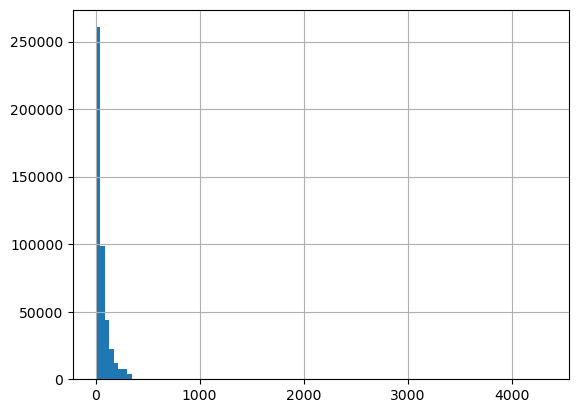

In [188]:
data['len_review'].hist(bins=100)

In [189]:
data[data['len_review']> 500]['Rating'].value_counts()

Rating
5    8
4    7
3    2
2    1
Name: count, dtype: int64

Какие многословные положительные отзывы! Удивительно.

In [190]:
data[data['len_review']> 500].head()

,Review,Rating,only_text,len_review
83917,"Для начала хочу предупредить, что данный отзыв...",3,Для начала хочу предупредить что данный отзыв ...,1141
114136,Теперь подробнее. Был куплен еще в 2009м! Рабо...,4,Теперь подробнее Был куплен еще в 2009м! Работ...,571
119589,Теперь подробнее. Был куплен еще в 2009м! Рабо...,4,Теперь подробнее Был куплен еще в 2009м! Работ...,571
125911,"Купил смарт 3 дня назад, пока очень доволен. Г...",5,Купил смарт 3 дня назад пока очень доволен Гла...,3072
135727,"ВНИМАНИЕ все, кто пользуется или пользовался S...",4,ВНИМАНИЕ все кто пользуется или пользовался So...,1617


In [191]:
data[data['len_review']== 0]['Rating'].value_counts()

Rating
5    88
4    41
1    24
3    19
2    10
Name: count, dtype: int64

In [192]:
data[data['len_review']== 1]['Rating'].value_counts()

Rating
5    1407
4     288
1     237
3     163
2     147
Name: count, dtype: int64

In [193]:
data[data['len_review']== 1].head(30)

,Review,Rating,only_text,len_review
172,Доволен,3,Доволен,1
174,Недорогой,5,Недорогой,1
467,Рекомендую,5,Рекомендую,1
631,Рекомендую.,5,Рекомендую,1
1148,Норм,3,Норм,1
1805,советую!!!,5,советую!!!,1
2323,Хорошее,4,Хорошее,1
2472,продам,3,продам,1
2645,Ужас,1,Ужас,1
2721,супер,5,супер,1


In [194]:
data[data['len_review']== 2]['Rating'].value_counts()

Rating
5    4329
4    1053
1     770
3     535
2     499
Name: count, dtype: int64

In [195]:
data[data['len_review']== 2].head(20)

,Review,Rating,only_text,len_review
134,Отличный смарт .,4,Отличный смарт,2
183,Телефон хороший,5,Телефон хороший,2
518,Очень доволен,5,Очень доволен,2
676,Очень довольна!!,5,Очень довольна!!,2
932,На троечку.,3,На троечку,2
1145,Отличный аппарат!,5,Отличный аппарат!,2
1153,Телефон супер!,5,Телефон супер!,2
1260,ЛюбЛюбля его...,5,ЛюбЛюбля его,2
1262,ЛюбЛюбля его...,5,ЛюбЛюбля его,2
1321,Классный телефончик,5,Классный телефончик,2


In [196]:
data[data['len_review']== 3].head(20)

,Review,Rating,only_text,len_review
5,6s gold 64gb,5,6s gold 64gb,3
51,"Дизайн , конечно, хорош.",1,Дизайн конечно хорош,3
81,покупать не рекомендую,3,покупать не рекомендую,3
177,Цена слишком завышена!,3,Цена слишком завышена!,3
517,Всё написал выше),5,Всё написал выше,3
542,Он реально лучший:),5,Он реально лучший,3
1030,пользуюсь с удовольствием),5,пользуюсь с удовольствием,3
1093,Пока доволен им....,4,Пока доволен им,3
1130,Супер телефон. 25746692,5,Супер телефон 25746692,3
1374,Что делать подскажите,3,Что делать подскажите,3


In [197]:
def get_num_exclamation_marks(row):
    num_exclamation_marks = row['only_text'].count('!')
    return  num_exclamation_marks
data['num_exclamation_marks'] = data.apply(get_num_exclamation_marks, axis = 1)
data['num_exclamation_marks'].describe()

count    457834.000000
mean          0.741282
std           2.432597
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max         251.000000
Name: num_exclamation_marks, dtype: float64

In [198]:
data.loc[data['num_exclamation_marks']>50,'num_exclamation_marks'] = 50

In [199]:
data['num_exclamation_marks'].value_counts()

num_exclamation_marks
0     339396
1      55446
2      18586
3      17755
4       8793
5       4448
6       3763
7       2341
8       1493
9       1244
10       886
11       726
12       582
13       436
14       299
15       268
16       213
17       150
18       127
19        98
20        88
21        86
50        82
23        65
24        52
26        46
27        40
22        37
25        36
30        30
29        22
32        22
28        21
36        19
39        18
31        18
33        17
34        13
35        11
48         9
40         8
42         7
46         6
41         6
43         5
47         5
44         4
37         4
45         4
38         2
49         1
Name: count, dtype: int64

<Axes: >

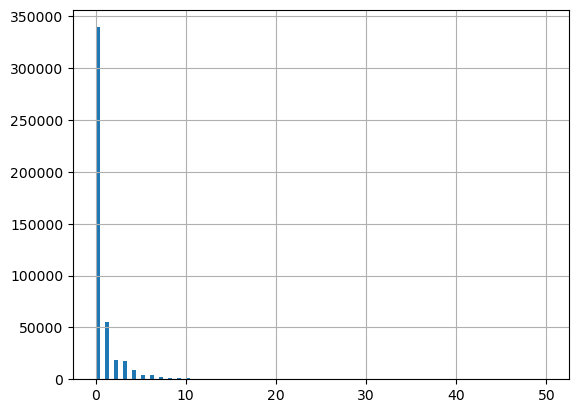

In [200]:
data['num_exclamation_marks'].hist(bins=100)

In [201]:
data.columns

Index(['Review', 'Rating', 'only_text', 'len_review', 'num_exclamation_marks'], dtype='object')

In [202]:
X = data.drop(['Review','Rating', ], axis = 1)

In [203]:
y =target = data['Rating']

In [204]:
train_x, test_x, train_y, test_y = train_test_split(X, y,
                                                   test_size=TEST_SIZE, random_state=RS,
                                                   )

In [205]:
text_features = X.select_dtypes(include='object').columns.tolist()
text_features

['only_text']

## Действительно лучшая модель

In [206]:
model_cb = CatBoostClassifier(iterations=1689,
                                depth = 6,
                                loss_function='MultiClass',
                                thread_count=-1, 
                                random_seed=RANDOM_STATE, 
                                verbose=0, 
                                text_features=text_features,
                                task_type = "GPU" 
                                
)

model_cb.fit(train_x, train_y, text_features=text_features, plot= True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [207]:
test_pred = model_cb.predict(test_x)
proba_test = model_cb.predict_proba(test_x)

train_pred = model_cb.predict(train_x)
proba_train = model_cb.predict_proba(train_x)
 
test_pred = model_cb.predict(test_x)
confusion = confusion_matrix(test_y, test_pred)
print(CR + classification_report(test_y,test_pred)) 

print(CR + 'Confusion Matrix\n')
print(confusion)
auc_tr = roc_auc_score(train_y, proba_train, multi_class='ovr')
auc_test = roc_auc_score(test_y, proba_test, multi_class='ovr')
print('AUC ROC train: ',auc_tr)
print('AUC ROC test: ',auc_test)
mse = mean_squared_error(test_y, test_pred)
rmse = root_mean_squared_error(test_y, test_pred)
mae = mean_absolute_error(test_y, test_pred)
print("Root Mean Squared Error на тестовой выборке:", rmse)
print("Mean Absolute Error на тестовой выборке:", mae)
r2 = r2_score(test_y, test_pred)
print("R2 на тестовой выборке:", r2)


              precision    recall  f1-score   support

           1       0.58      0.62      0.60      8652
           2       0.56      0.37      0.45      8867
           3       0.52      0.43      0.47     13286
           4       0.58      0.42      0.49     26766
           5       0.74      0.89      0.81     56888

    accuracy                           0.67    114459
   macro avg       0.60      0.55      0.56    114459
weighted avg       0.65      0.67      0.65    114459


Confusion Matrix

[[ 5371   845   876   380  1180]
 [ 1842  3294  1503   829  1399]
 [ 1127   967  5647  2739  2806]
 [  438   481  1876 11371 12600]
 [  493   304   906  4383 50802]]
AUC ROC train:  0.9201284539975175
AUC ROC test:  0.8829963829187928
Root Mean Squared Error на тестовой выборке: 0.9546455721050378
Mean Absolute Error на тестовой выборке: 0.48104561458688266
R2 на тестовой выборке: 0.4315730016985395


In [209]:
with open(LOCAL_PATH + 'model_cb.pkl', 'wb') as f:
    pickle.dump(model_cb, f)

Text(0.5, 1.0, 'Важность признаков Catboost ')

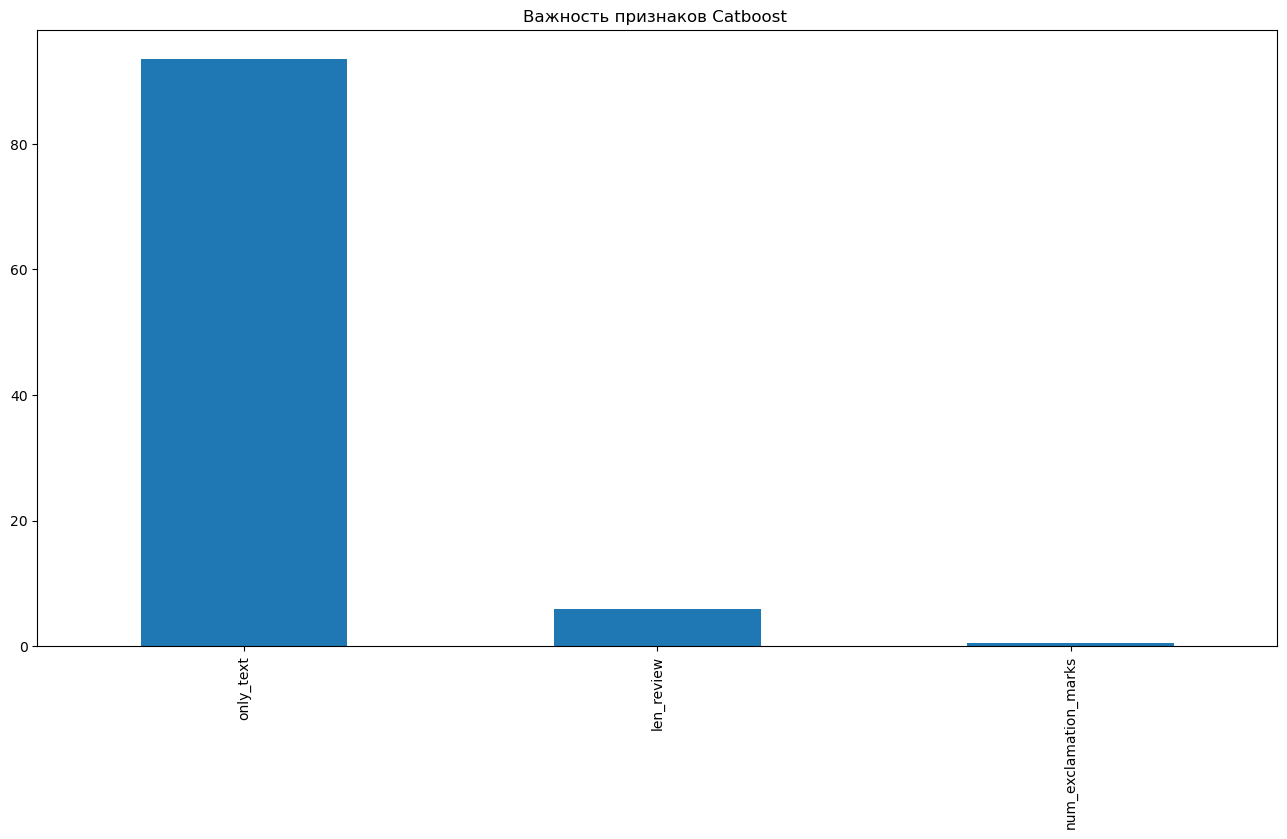

In [210]:
cat_imp = pd.Series(model_cb.feature_importances_, X.columns)
cat_imp.plot.bar(figsize=(16,8)).set_title("Важность признаков Catboost ")

In [211]:
data['only_text']

0         3D Touch просто восхитительная вещь! Заряд дер...
1         Отключается при температуре близкой к нулю неп...
2         В Apple окончательно решили не заморачиваться ...
3         Постарался наиболее ёмко и коротко описать все...
4          Достойный телефон Пользоваться одно удовольствие
                                ...                        
457829    удобный всё работает отлично звонит играет сни...
457830    прошло больше года притензий нет при моей нагр...
457831    мой первый аппарат на андроиде На данный момен...
457832    Разбил iphone и не было желания покупать новый...
457833                Очень доволен покупкой и всем советую
Name: only_text, Length: 457834, dtype: object

In [212]:
def get_word_tokens(row):
    try:
        return word_tokenize(row['only_text'])
    except:
        return ''
data['tokens_from_review'] = data.apply(get_word_tokens, axis = 1)
data['tokens_from_review'].head()

0    [3D, Touch, просто, восхитительная, вещь, !, З...
1    [Отключается, при, температуре, близкой, к, ну...
2    [В, Apple, окончательно, решили, не, заморачив...
3    [Постарался, наиболее, ёмко, и, коротко, описа...
4    [Достойный, телефон, Пользоваться, одно, удово...
Name: tokens_from_review, dtype: object

In [213]:
tqdm.pandas()
morph = MorphAnalyzer()
def lemmatize_it(row):
    lemmas = [morph.parse(word)[0].normal_form for word in row['tokens_from_review']]
    lemmatized_text = ' '.join(lemmas)
    return  lemmatized_text

data['lemmas_from_review'] = data.apply(lemmatize_it, axis = 1)
data['lemmas_from_review'].head()

0    3d touch просто восхитительный вещь ! заряд де...
1    отключаться при температура близкий к нуль неп...
2    в apple окончательно решить не заморачиваться ...
3    постараться наиболее ёмко и коротко описать вс...
4     достойный телефон пользоваться один удовольствие
Name: lemmas_from_review, dtype: object

и оно даже строчное сразу, отлично. Теперь векторизация

In [214]:
data.columns

Index(['Review', 'Rating', 'only_text', 'len_review', 'num_exclamation_marks',
       'tokens_from_review', 'lemmas_from_review'],
      dtype='object')

In [215]:
X= data.drop(['Review', 'Rating', 'only_text','tokens_from_review', ],axis = 1)

train_x, test_x, train_y, test_y = train_test_split(X, y,
                                                   test_size=TEST_SIZE, random_state=RS,
                                                   )

In [216]:
vec_tr = TfidfVectorizer(ngram_range=(1, 2), max_df=0.4, tokenizer=word_tokenize, stop_words=noise)
bow_tr = vec_tr.fit_transform(train_x['lemmas_from_review'])

vec_train = pd.DataFrame.sparse.from_spmatrix(bow_tr, columns=vec_tr.get_feature_names_out()
                                             )

C:\Users\term\anaconda3\envs\nlpenv\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [217]:
list_ngramm_imp = vec_train.columns
len(list_ngramm_imp)

2665037

При таком же режиме до чистки размер был 4221365, а теперь вот 2509712. Круто же!

In [218]:
ngramm_imp = vec_train.sum().sort_values(ascending = False)
ngramm_imp.head(20)

!               9298.263368
хороший         5114.720905
очень           4805.788099
! !             4802.657744
это             4709.598412
всё             4340.027599
купить          3100.196805
довольный       3083.344867
цена            3077.819871
аппарат         3072.911716
отличный        3055.742767
год             2969.335737
деньга          2864.064331
брать           2862.926953
свой             2844.95451
весь            2736.838795
советовать      2637.801856
модель          2583.355431
экран           2543.420915
пользоваться    2529.956316
dtype: Sparse[float64, 0]

In [219]:
vec_tr.get_feature_names_out()[:40]

array(['!', '! !', '! 0', '! 00', '! 01', '! 011273', '! 015271', '! 02',
       '! 04', '! 040272', '! 05', '! 1', '! 10', '! 100', '! 1000',
       '! 10000', '! 1000р', '! 100500', '! 100грамм', '! 100раз',
       '! 10500', '! 108', '! 10990', '! 10к', '! 10т', '! 10тр', '! 10х',
       '! 11', '! 111', '! 11200', '! 113', '! 11500', '! 12', '! 1200',
       '! 12400521', '! 12500р', '! 128', '! 12990', '! 12гб', '! 13'],
      dtype=object)

In [220]:
vec_ts = TfidfVectorizer(ngram_range=(1, 2), max_df=0.4, tokenizer=word_tokenize, stop_words=noise)
bow_ts = vec_ts.fit_transform(test_x['lemmas_from_review'])

vec_test = pd.DataFrame.sparse.from_spmatrix(bow_ts, columns=vec_ts.get_feature_names_out()
                                             )

C:\Users\term\anaconda3\envs\nlpenv\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [221]:
ngramm_imp_ts = vec_test.sum().sort_values(ascending = False)
ngramm_imp_ts.head(20)

!               3191.496925
хороший          1727.23985
! !             1657.085598
очень           1624.158412
это             1611.610231
всё             1474.916089
купить          1059.151309
аппарат         1058.025522
отличный        1053.181302
цена            1043.237135
довольный       1041.732814
год              1017.75187
деньга           973.988599
свой             966.977554
брать            962.940891
весь             940.854394
советовать       896.534215
модель           883.233059
экран             875.08706
пользоваться     850.052807
dtype: Sparse[float64, 0]

In [222]:
len(ngramm_imp_ts)

1515887

In [223]:
columns_test = set(list(vec_test.columns))
columns_train = set(list(vec_train.columns))

In [224]:
add_list_test = [x for x in columns_test if x not in columns_train]
len(add_list_test)

228235

In [225]:
add_list_test

['ничего бред',
 'стабильный гибкий',
 '299 !',
 'молодец действительно',
 '5990 объём',
 'пять бывать',
 'выложилсить плохо',
 'мапёс режим',
 'всякий кредит',
 'коммуникация gps',
 'обрезать производительный',
 'ругаться самс',
 'превращаться невыполнимый',
 '2123 ха',
 'навигатор 1200мгц',
 'текст p',
 'нагреться место',
 'трей набор',
 'сантиметр туда',
 'продавец спроить',
 'поэтому регулироваться',
 '16000 плюс',
 'несколько переход',
 'разблокировка задрать',
 'узнать разрешение',
 '24 мтс',
 'лёт игра',
 'готовиться короткий',
 'пятно возле',
 'значительно низкий',
 'сектор меню',
 'некуда поставить',
 'каприз очень',
 'серьёзный последствие',
 'впечатление недельный',
 'фликра общий',
 'перезагрузка традиционно',
 'гарантия включеный',
 'поскольку крутой',
 'обзор счёт',
 'всё го',
 'необычный разнообразие',
 'качественный детализация',
 'рассрочка оплачивать',
 'кадр нельзя',
 'телефон раздутый',
 'пофоткать че',
 'готовый ярость',
 's6с',
 'потребление сутки',
 'пофоткаться 

In [226]:
add_list_train = [x for x in columns_train if x not in columns_test]
len(add_list_train)

1377385

И у наших фич есть расхождения, связанные с тем, что мы их тренировали отдельно.
Ну сперва добавлять не будем, удалим. Будем считать, что это малоупотребимые фичи.

In [227]:
vec_train_drop = vec_train.drop(add_list_train, axis = 1)
vec_test_drop = vec_test.drop(add_list_test, axis = 1)

In [228]:
vec_test_drop = vec_test_drop[vec_train_drop.columns]

In [229]:
model_cb = CatBoostClassifier(iterations=1200,
                                depth = 3,
                                loss_function='MultiClass',
                                thread_count=-1, 
                                random_seed=RANDOM_STATE, 
                                verbose=0, 
                                #text_features=text_features,
                                #task_type = "GPU" 
                                
)

model_cb.fit(vec_train_drop, train_y, plot= True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [230]:
train_pred = model_cb.predict(vec_train_drop)
proba_train = model_cb.predict_proba(vec_train_drop)
 
test_pred = model_cb.predict(vec_test_drop)
proba_test = model_cb.predict_proba(vec_test_drop)

confusion = confusion_matrix(test_y, test_pred)

print(CR + classification_report(test_y,test_pred)) 

print(CR + 'Confusion Matrix\n')
print(confusion)
auc_tr = roc_auc_score(train_y, proba_train, multi_class='ovr')
auc_test = roc_auc_score(test_y,  proba_test, multi_class='ovr')
print('AUC train: ', auc_tr)
print('AUC test: ', auc_test)
mse = mean_squared_error(test_y, test_pred)

rmse = root_mean_squared_error(test_y, test_pred)
mae = mean_absolute_error(test_y, test_pred)
print("Root Mean Squared Error на тестовой выборке:", rmse)
print("Mean Absolute Error на тестовой выборке:", mae)
r2 = r2_score(test_y, test_pred)
print("R2 на тестовой выборке:", r2)


              precision    recall  f1-score   support

           1       0.51      0.40      0.45      8652
           2       0.40      0.13      0.20      8867
           3       0.41      0.16      0.23     13286
           4       0.51      0.22      0.31     26766
           5       0.61      0.94      0.74     56888

    accuracy                           0.58    114459
   macro avg       0.49      0.37      0.38    114459
weighted avg       0.54      0.58      0.52    114459


Confusion Matrix

[[ 3467   767   725   273  3420]
 [ 1866  1155  1157   613  4076]
 [  963   638  2122  2246  7317]
 [  288   207   899  5848 19524]
 [  258   108   282  2495 53745]]
AUC train:  0.8251728626520357
AUC test:  0.8188417409823364
Root Mean Squared Error на тестовой выборке: 1.2243328407913563
Mean Absolute Error на тестовой выборке: 0.688045501009095
R2 на тестовой выборке: 0.06504788155172492


In [231]:
cat_imp = pd.DataFrame(model_cb.feature_importances_, vec_train_drop.columns)
cat_imp.columns = ['imp']
cat_imp = cat_imp.sort_values(by = 'imp', ascending = False)
cat_imp.shape[0]

1287652

In [232]:
cat_imp[cat_imp['imp']> 0.1].head(40)

,imp
отличный,5.749550
не советовать,4.694014
довольный,4.256917
целое,3.034626
не рекомендовать,2.682494
не пожалеть,2.498604
не покупать,1.630699
рекомендовать,1.482180
!,1.423014
разочаровать,1.374756


Сколько у нас признаков с важностью > 0.1? 180 0.01? -607 0.001? 871 0.0001? -896 0.00001? 898. Больше 0.000000000001 - опять 898. В принципе больше нуля кэтбуст счёл только 898 признаков. Интересно. Это какое облегчение модели будет!!! Проверим только эти 898

In [233]:
cat_imp[cat_imp['imp']> 0].shape[0]

893

Text(0.5, 1.0, 'Важность признаков Catboost ')

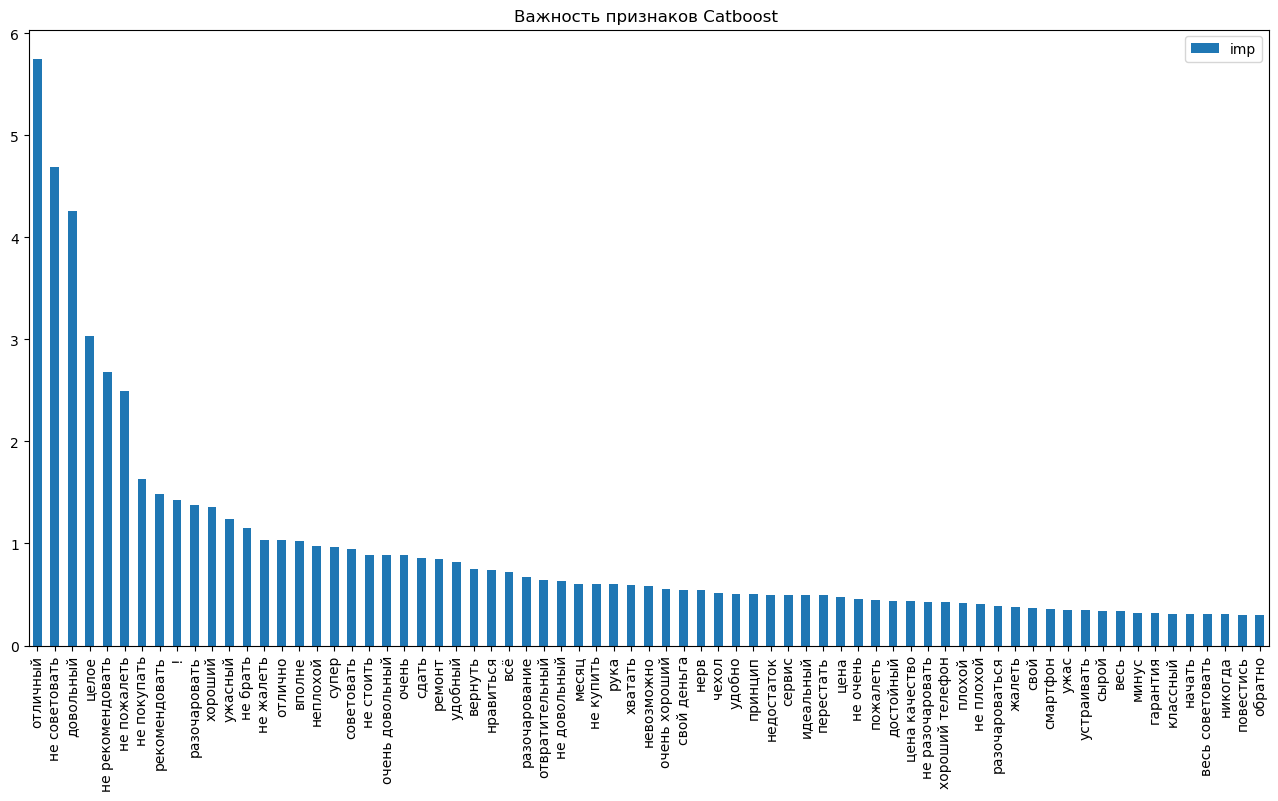

In [234]:

cat_imp[cat_imp['imp']> 0.3].plot.bar(figsize=(16,8)).set_title("Важность признаков Catboost ")

In [235]:
cat_imp = cat_imp.reset_index()
cat_imp

,index,imp
0,отличный,5.749550
1,не советовать,4.694014
2,довольный,4.256917
3,целое,3.034626
4,не рекомендовать,2.682494
...,...,...
1287647,именно писать,0.000000
1287648,именно пи,0.000000
1287649,именно периодический,0.000000
1287650,именно периодически,0.000000


In [236]:
cat_imp_list = set(cat_imp[cat_imp['imp']> 0]['index'].tolist())
len(cat_imp_list)

893

In [237]:
cat_imp_list

{'!',
 '100',
 '128',
 '2 балл',
 '2 год',
 '2 звезда',
 '2010 год',
 '3 балл',
 '3 звезда',
 '3000',
 '32',
 '4',
 '4 балл',
 '4 год',
 '4 звезда',
 '4 поставить',
 '4g',
 '4ку',
 '5',
 '5 5',
 '6 год',
 'android',
 'galaxy',
 'gps',
 'hd',
 'huawei',
 'iphone',
 'lte',
 'mi',
 'nfc',
 'nokia',
 'pro',
 'ru',
 'shell',
 'sms',
 'windows !',
 'абсолютно',
 'айфон',
 'аккуратный использование',
 'али',
 'аналог',
 'аппарат 4',
 'аппарат неплохой',
 'аппарат около',
 'аппарат хороший',
 'аська',
 'б',
 'б не',
 'барахло',
 'батарея',
 'батарея садиться',
 'беда',
 'безумно',
 'бесить',
 'бесплатный',
 'бесполезный',
 'блокировка',
 'больший',
 'большой не',
 'большой никакой',
 'большой никогда',
 'бомба',
 'бояться',
 'брак',
 'браковать',
 'брать !',
 'брать не',
 'быстро',
 'быстрый',
 'бюджетный модель',
 'вариант',
 'великолепный',
 'вера правда',
 'вернуть',
 'версия',
 'весь',
 'весь рекомендовать',
 'весь советовать',
 'ветер',
 'взгляд',
 'вздумать',
 'вздумать покупать',
 'взят

Список готов, поехали:

In [238]:
vec_train_short = vec_train_drop[list(cat_imp_list)]
 
vec_test_short = vec_test_drop[list(cat_imp_list)]

In [239]:
model_cb = CatBoostClassifier(iterations=1500,
                                depth = 5,
                                loss_function='MultiClass',
                                thread_count=-1, 
                                random_seed=RANDOM_STATE, 
                                verbose=0, 
                                #text_features=text_features,
                                #task_type = "GPU" 
                                
)

#model_cb.fit(vec_train_drop, train_y, plot= True)
model_cb.fit(vec_train_short, train_y, plot= True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [240]:
train_pred = model_cb.predict(vec_train_short)
proba_train = model_cb.predict_proba(vec_train_short)
 
test_pred = model_cb.predict(vec_test_short)
proba_test = model_cb.predict_proba(vec_test_short)

confusion = confusion_matrix(test_y, test_pred)

print(CR + classification_report(test_y,test_pred)) 

print(CR + 'Confusion Matrix\n')
print(confusion)
auc_tr = roc_auc_score(train_y, proba_train, multi_class='ovr')
auc_test = roc_auc_score(test_y,  proba_test, multi_class='ovr')
print('AUC train: ', auc_tr)
print('AUC test: ', auc_test)
mse = mean_squared_error(test_y, test_pred)

rmse = root_mean_squared_error(test_y, test_pred)
mae = mean_absolute_error(test_y, test_pred)
print("Root Mean Squared Error на тестовой выборке:", rmse)
print("Mean Absolute Error на тестовой выборке:", mae)
r2 = r2_score(test_y, test_pred)
print("R2 на тестовой выборке:", r2)


              precision    recall  f1-score   support

           1       0.52      0.44      0.47      8652
           2       0.41      0.16      0.23      8867
           3       0.42      0.21      0.28     13286
           4       0.52      0.26      0.34     26766
           5       0.63      0.93      0.75     56888

    accuracy                           0.59    114459
   macro avg       0.50      0.40      0.42    114459
weighted avg       0.55      0.59      0.54    114459


Confusion Matrix

[[ 3787   890   857   318  2800]
 [ 1926  1414  1402   711  3414]
 [ 1021   737  2731  2505  6292]
 [  314   244  1139  6900 18169]
 [  288   135   418  2957 53090]]
AUC train:  0.8394018316791092
AUC test:  0.8290292544471052
Root Mean Squared Error на тестовой выборке: 1.163451792539536
Mean Absolute Error на тестовой выборке: 0.6439511091307805
R2 на тестовой выборке: 0.15571872311106616


In [241]:
vec_train_short = vec_train_short.merge(X[['len_review', 'num_exclamation_marks']], how='left', left_index=True, right_index=True)
vec_test_short = vec_test_short.merge(X[['len_review', 'num_exclamation_marks']], how='left', left_index=True, right_index=True)

In [242]:
model_cb.fit(vec_train_short, train_y, plot= True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [243]:
train_pred = model_cb.predict(vec_train_short)
proba_train = model_cb.predict_proba(vec_train_short)
 
test_pred = model_cb.predict(vec_test_short)
proba_test = model_cb.predict_proba(vec_test_short)

confusion = confusion_matrix(test_y, test_pred)

print(CR + classification_report(test_y,test_pred)) 

print(CR + 'Confusion Matrix\n')
print(confusion)
auc_tr = roc_auc_score(train_y, proba_train, multi_class='ovr')
auc_test = roc_auc_score(test_y,  proba_test, multi_class='ovr')
print('AUC train: ', auc_tr)
print('AUC test: ', auc_test)
mse = mean_squared_error(test_y, test_pred)

rmse = root_mean_squared_error(test_y, test_pred)
mae = mean_absolute_error(test_y, test_pred)
print("Root Mean Squared Error на тестовой выборке:", rmse)
print("Mean Absolute Error на тестовой выборке:", mae)
r2 = r2_score(test_y, test_pred)
print("R2 на тестовой выборке:", r2)


              precision    recall  f1-score   support

           1       0.51      0.43      0.47      8652
           2       0.41      0.16      0.23      8867
           3       0.42      0.21      0.28     13286
           4       0.51      0.26      0.34     26766
           5       0.63      0.93      0.75     56888

    accuracy                           0.59    114459
   macro avg       0.50      0.40      0.41    114459
weighted avg       0.55      0.59      0.54    114459


Confusion Matrix

[[ 3745   886   898   314  2809]
 [ 1941  1387  1419   724  3396]
 [ 1006   742  2764  2480  6294]
 [  309   243  1136  6878 18200]
 [  307   111   423  2980 53067]]
AUC train:  0.8394218861037354
AUC test:  0.8289047579610592
Root Mean Squared Error на тестовой выборке: 1.164307542371988
Mean Absolute Error на тестовой выборке: 0.6448946784438095
R2 на тестовой выборке: 0.154476283548861


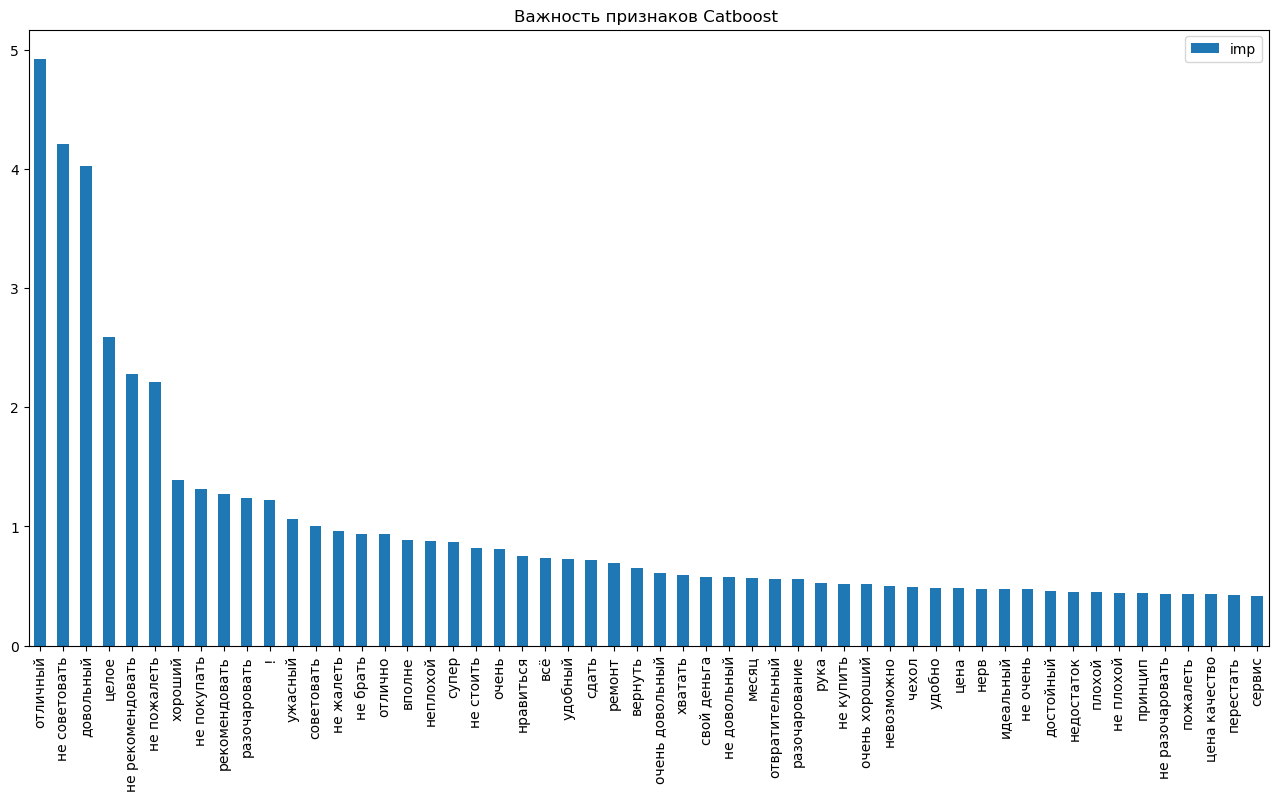

In [244]:
cat_imp = pd.DataFrame(model_cb.feature_importances_, vec_train_short.columns)
cat_imp.columns = ['imp']
cat_imp = cat_imp.sort_values(by = 'imp', ascending = False)
cat_imp.shape[0]
cat_imp[cat_imp['imp']> 0.4].plot.bar(figsize=(16,8)).set_title("Важность признаков Catboost ")
#plt.xticks(rotation = 45)
plt.show()

Лучший скор получен с моделью
```
CatBoostClassifier
    (iterations=1689,
    depth = 6,                                
    loss_function='MultiClass',
    thread_count=-1, 
    random_seed=RANDOM_STATE, 
    verbose=0, 
    text_features=text_features,
    task_type = "GPU" 
                                
)
Метрики и матрица:

              precision    recall  f1-score   support

           1       0.58      0.62      0.60      8652
           2       0.56      0.37      0.45      8867
           3       0.52      0.43      0.47     13286
           4       0.58      0.42      0.49     26766
           5       0.74      0.89      0.81     56888

    accuracy                           0.67    114459
   macro avg       0.60      0.55      0.56    114459
weighted avg       0.65      0.67      0.65    114459


Confusion Matrix

[[ 5371   845   876   380  1180]
 [ 1842  3294  1503   829  1399]
 [ 1127   967  5647  2739  2806]
 [  438   481  1876 11371 12600]
 [  493   304   906  4383 50802]]
 
AUC ROC train:  0.9201284539975175
AUC ROC test:  0.8829963829187928

Root Mean Squared Error на тестовой выборке: 0.9546455721050378
Mean Absolute Error на тестовой выборке: 0.48104561458688266
R2 на тестовой выборке: 0.4315730016985395
```
Метрики получены на тексте, токенизированном и лемматизированном пайморфом. Это лучший вариант, в том числе в сравнении с векторизацией.

Конец первой части, во второй части - подборка нейронных сетей.